In [519]:
from qutip import *
import numpy as np
import scipy
import cmath
import matplotlib.pyplot as plt
from numpy.random import seed
from numpy.random import rand
from itertools import product
from scipy.misc import derivative
from scipy import optimize
seed(1)

In [520]:
#operator definitionis
N = 2
si = qeye(2)
sx = 0.5*sigmax()
sy = 0.5*sigmay()
sz = 0.5*sigmaz()

In [521]:
#make list of tensor products
sx_list = []
sy_list = []
sz_list = []

for n in range(N):
    op_list = []
    for m in range(N):
        op_list.append(si)

    op_list[n] = sx
    sx_list.append(tensor(op_list))

    op_list[n] = sy
    sy_list.append(tensor(op_list))

    op_list[n] = sz
    sz_list.append(tensor(op_list))


In [522]:
#Construct Hamiltonian
B = 0
A0 = 1
H = B*sz_list[0] 
for n in range(N-1):
    H += A0*sz_list[0]*sz_list[n+1] + A0*sx_list[0]*sx_list[n+1] + A0*sy_list[0]*sy_list[n+1]
print(H)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.25  0.    0.    0.  ]
 [ 0.   -0.25  0.5   0.  ]
 [ 0.    0.5  -0.25  0.  ]
 [ 0.    0.    0.    0.25]]


In [523]:
#Find Groundstate
H.groundstate()

(-0.7500000000000001,
 Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
 Qobj data =
 [[ 0.        ]
  [ 0.70710678]
  [-0.70710678]
  [ 0.        ]])

In [524]:
#Make basis
Sbasis = []
for i in range(N):
    for j in range(N):
        Sbasis.append(tensor([basis(N,i),basis(N,j)]))
print(Sbasis)

[Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]], Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [1.]
 [0.]
 [0.]], Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [1.]
 [0.]], Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [1.]]]


In [525]:
#get sz values for basis states
sz = np.zeros((2**N,N), dtype = complex)
a = [[1 for j in range(N)] for i in range(2**N)]
for i in range(2**N):
    for j in range(N):
        #matrix element <bra|Sz|ket>
        sz[i][j] = sz_list[j].matrix_element(Sbasis[i],Sbasis[i])

print(sz)

[[ 0.5+0.j  0.5+0.j]
 [ 0.5+0.j -0.5+0.j]
 [-0.5+0.j  0.5+0.j]
 [-0.5+0.j -0.5+0.j]]


In [526]:
#Define RBM Parameters
M = 2
alp = M/N
#Number of parameters 
num = N+M+N*M

#par = np.random.rand(num)
par = np.array([0,0,0,0,0,0,0,0,0,0,0.5*np.pi,0.25*np.pi,0.5*np.pi,-1.5*np.pi,0,-0.5*np.pi])




In [527]:
#Function to give RBM wavefuntion
def RBM_ansatz(par, Sbasis, N, M,sz):
    #make parmeters complex
    parC = np.vectorize(complex)(par[:num],par[num:])
    a = parC[:N]
    b = parC[N:N+M]
    W = parC[N+M:].reshape(N,M)
    expTerm = np.zeros(2**N, dtype = complex)
    coshTerm = np.zeros((M,2**N), dtype = complex)
    hidProduct = np.zeros(2**N, dtype = complex)
    psiMValues = np.zeros(2**N, dtype = complex)
    psiM = 0*Sbasis[0]

    for i in range(2**N):
        for m in range(M):
            coshTerm[m][i] = 2*np.cosh(np.dot(W[m],sz[i]) + b[m])
    hidProduct = np.prod(coshTerm, axis = 0) 
    print(coshTerm)
    
    for i in range(2**N):
        expTerm[i] = np.exp(np.dot(a,sz[i]))
        psiMValues[i] = expTerm[i]*hidProduct[i]
        psiM += psiMValues[i]*Sbasis[i]
    psiNorm = psiM.unit()
    return psiNorm

test = RBM_ansatz(par, Sbasis, N, M,sz)
test


[[ 2.0000000e+00+0.j -3.6739404e-16-0.j  1.2246468e-16+0.j
  -2.0000000e+00+0.j]
 [ 2.0000000e+00+0.j  1.2246468e-16+0.j  2.0000000e+00+0.j
   1.2246468e-16+0.j]]


Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]]

In [528]:
#Variation Energy Definition
def varEnergy(par, Sbasis, N, M,sz, H):
    psiM = RBM_ansatz(par, Sbasis, N, M, sz)
    E = expect(H,psiM)
    norm = psiM.norm()**2
    Enorm = E/norm
    return Enorm

varEnergy(par, Sbasis, N, M,sz, H)

[[ 2.0000000e+00+0.j -3.6739404e-16-0.j  1.2246468e-16+0.j
  -2.0000000e+00+0.j]
 [ 2.0000000e+00+0.j  1.2246468e-16+0.j  2.0000000e+00+0.j
   1.2246468e-16+0.j]]


0.25

In [529]:
#Energy Partials
def gradEnergy(par, Sbasis, N, M,sz, H):
    eps = 0.00001
    return optimize.approx_fprime(par,varEnergy,eps,Sbasis, N, M,sz, H)

In [530]:
#Gradient Descent 
def updateParameters(par, Sbasis, N, M,sz, H, learning_rate):
    #Find partials
    eps = 0.000001
    partials = optimize.approx_fprime(par,varEnergy,eps,Sbasis, N, M,sz, H)
    diff_par = (-1)*partials*learning_rate
    diff = np.max(diff_par)
    
    
    for i in range(N+M+N*M):
        par[i] += diff_par[i]      
    
    return par, diff



In [537]:
#Minimize Energy
E = []
iteration = []
diff = 1
itValue = 0

while diff > 0.00000001 and itValue < 1000:
    E.append(varEnergy(par, Sbasis, N, M,sz, H))
    newParams = updateParameters(par, Sbasis, N, M,sz, H, 0.3)
    diff = newParams[1]
    #count interations
    itValue = itValue + 1
    iteration.append(itValue)



[[ 2.67428136e+00+0.00000000e+00j -3.69289568e-16-2.03424651e-01j
   9.07100781e-16-1.46784524e+01j -7.47278467e+00+8.81767047e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.35260931e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15395018e-07j]]
[[ 2.67428136e+00+0.00000000e+00j -3.69289568e-16-2.03424651e-01j
   9.07100781e-16-1.46784524e+01j -7.47278467e+00+8.81767047e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.35260931e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15395018e-07j]]
[[ 2.67428136e+00+0.00000000e+00j -3.69289568e-16-2.03424651e-01j
   9.07100781e-16-1.46784524e+01j -7.47278467e+00+8.81767047e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.35260931e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15395018e-07j]]
[[ 2.67428136e+00+0.00000000e+00j -3.69289568e-16-2.03424651e-01j
   9.07100781e-16-1.46784524e+01j -7.47278467e+00+8.81767047e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.35260931e-05j


   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15336732e-07j]]
[[ 2.67430617e+00+8.87681459e-07j -1.00514258e-06-2.03092046e-01j
   7.41352450e-06-1.46915412e+01j -7.47785345e+00+3.60271746e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.36738833e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15336732e-07j]]
[[ 2.67430617e+00+0.00000000e+00j -3.69283391e-16-2.03092046e-01j
   9.07894905e-16-1.46915412e+01j -7.47785345e+00+8.82411280e-16j]
 [ 2.00000000e+00-5.35128957e-11j -1.00000000e-06-4.36738833e-05j
   2.00000000e+00+3.19336224e-11j  1.00000000e-06-5.15336732e-07j]]
[[ 2.67430617e+00+0.00000000e+00j -3.69283391e-16-2.03092046e-01j
   9.07894905e-16-1.46915412e+01j -7.47785345e+00+8.82411280e-16j]
 [ 2.00000000e+00-5.35128957e-11j  1.00000000e-06-4.36738833e-05j
   2.00000000e+00-3.19336224e-11j  1.00000000e-06-5.15336732e-07j]]
[[ 2.67431029e+00+0.00000000e+00j -3.69282365e-16-2.03036734e-01j
   9.08027029e-16-1.46937188e+01j -7.47869670e+00+8.82518452e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15353385e-07j]]
[[ 2.67433172e+00+0.00000000e+00j -3.69277228e-16-2.02759681e-01j
   9.08687116e-16-1.47045982e+01j -7.48290278e+00+8.83053006e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.38217150e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15353385e-07j]]
[[ 2.67433083e+00+0.00000000e+00j -3.69277246e-16-2.02760686e-01j
   9.08686666e-16-1.47045908e+01j -7.48290638e+00+8.83053464e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.28217150e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51535338e-06j]]
[[ 2.67433083e+00+0.00000000e+00j -3.69277246e-16-2.02760686e-01j
   9.08686666e-16-1.47045908e+01j -7.48290638e+00+8.83053464e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.48217150e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51535338e-06j]]
[[ 2.67433083e+00+0.00000000e+00j -3.69277246e-16-2.02760686e-01j
   9.08686666e-16-1.47045908e+01j -7.48290638e+00+8.83053464e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15328405e-07j]]
[[ 2.67435128e+00+0.00000000e+00j -3.69272151e-16-2.02485497e-01j
   9.09344674e-16-1.47154357e+01j -7.48710513e+00+8.83587063e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.39448748e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15328405e-07j]]
[[ 2.67435305e+00+0.00000000e+00j -3.69272188e-16-2.02487507e-01j
   9.09345575e-16-1.47154506e+01j -7.48711234e+00+8.83587980e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.39448748e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15328405e-07j]]
[[ 2.67435128e+00+0.00000000e+00j -3.69272151e-16-2.02485497e-01j
   9.09344674e-16-1.47154357e+01j -7.48710513e+00+8.83587063e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.19448748e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16+1.48467160e-06j]]
[[ 2.67435217e+00+0.00000000e+00j -3.69272170e-16-2.02486502e-01j
   9.09344223e-16-1.47154283e+01j -7.48710152e+00+8.83586605e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15328405e-07j]]
[[ 2.67437568e+00+8.87733810e-07j -1.00509542e-06-2.02156394e-01j
   7.43179295e-06-1.47284142e+01j -7.49212928e+00+3.61012469e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.40925567e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15328405e-07j]]
[[ 2.67437568e+00+0.00000000e+00j -3.69266066e-16-2.02156394e-01j
   9.10132144e-16-1.47284142e+01j -7.49212928e+00+8.84225529e-16j]
 [ 2.00000000e+00-5.40252733e-11j -1.00000000e-06-4.40925567e-05j
   2.00000000e+00+3.22366592e-11j  1.00000000e-06-5.15328405e-07j]]
[[ 2.67437568e+00+0.00000000e+00j -3.69266066e-16-2.02156394e-01j
   9.10132144e-16-1.47284142e+01j -7.49212928e+00+8.84225529e-16j]
 [ 2.00000000e+00-5.40252733e-11j  1.00000000e-06-4.40925567e-05j
   2.00000000e+00-3.22366592e-11j  1.00000000e-06-5.15328405e-07j]]
[[ 2.67437973e+00+0.00000000e+00j -3.69265055e-16-2.02101662e-01j
   9.10263163e-16-1.47305736e+01j -7.49296512e+00+8.84331744e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15328405e-07j]]
[[ 2.67440397e+00+0.00000000e+00j -3.69259008e-16-2.01773979e-01j
   9.11047931e-16-1.47435073e+01j -7.49797115e+00+8.84967869e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.32647689e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51532840e-06j]]
[[ 2.67440397e+00+0.00000000e+00j -3.69259008e-16-2.01773979e-01j
   9.11047931e-16-1.47435073e+01j -7.49797115e+00+8.84967869e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.52647689e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51532840e-06j]]
[[ 2.67440397e+00+0.00000000e+00j -3.69259008e-16-2.01773979e-01j
   9.11047931e-16-1.47435073e+01j -7.49797115e+00+8.84967869e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.42647689e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15328405e-07j]]
[[ 2.67440397e+00+0.00000000e+00j -3.69259008e-16-2.01773979e-01j
   9.11047931e-16-1.47435073e+01j -7.49797115e+00+8.84967869e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15353385e-07j]]
[[ 2.67443206e+00+1.77555255e-06j  2.01011423e-06-2.01393208e-01j
   1.48934467e-05-1.47585485e+01j -7.50379203e+00-7.23235057e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.44369895e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15353385e-07j]]
[[ 2.67443206e+00+0.00000000e+00j -3.69251994e-16-2.01393208e-01j
   9.11960588e-16-1.47585485e+01j -7.50379203e+00+8.85707498e-16j]
 [ 2.00000000e+00-1.08893514e-10j -2.00000000e-06-4.44369895e-05j
   2.00000000e+00-6.49718779e-11j -2.00000000e-06-5.15353385e-07j]]
[[ 2.67443206e+00+8.87776275e-07j  1.00505712e-06-2.01393208e-01j
  -7.44672333e-06-1.47585485e+01j -7.50379203e+00+3.61617529e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.44369895e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15353385e-07j]]
[[ 2.67443206e+00+8.87776275e-07j -1.00505712e-06-2.01393208e-01j
   7.44672333e-06-1.47585485e+01j -7.50379203e+00+3.61617529e-06j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15345058e-07j]]
[[ 2.67446572e+00+0.00000000e+00j -3.69244067e-16-2.00962045e-01j
   9.13000729e-16-1.47756903e+01j -7.51042622e+00+8.86550416e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.46337904e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15345058e-07j]]
[[ 2.67446394e+00+0.00000000e+00j -3.69244030e-16-2.00960035e-01j
   9.12999824e-16-1.47756754e+01j -7.51041898e+00+8.86549497e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.26337904e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16+1.48465494e-06j]]
[[ 2.67446483e+00+0.00000000e+00j -3.69244049e-16-2.00961040e-01j
   9.12999371e-16-1.47756680e+01j -7.51041536e+00+8.86549037e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.46337904e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15345058e-07j]]
[[ 2.67446483e+00+0.00000000e+00j -3.69244012e-16-2.00959030e-01j
   9.13000276e-16-1.47756829e+01j -7.51041536e+00+8.86549037e-16j

[[ 2.67449164e+00+0.00000000e+00j -3.69237107e-16-2.00582739e-01j
   9.13905855e-16-1.47906068e+01j -7.51619545e+00+8.87283389e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.58058611e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51538669e-06j]]
[[ 2.67449164e+00+0.00000000e+00j -3.69237107e-16-2.00582739e-01j
   9.13905855e-16-1.47906068e+01j -7.51619545e+00+8.87283389e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.48058611e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15386692e-07j]]
[[ 2.67449164e+00+0.00000000e+00j -3.69237107e-16-2.00582739e-01j
   9.13905855e-16-1.47906068e+01j -7.51619545e+00+8.87283389e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.48058611e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15386692e-07j]]
[[ 2.67449164e+00+1.77564228e-06j  2.01003319e-06-2.00582739e-01j
   1.49252153e-05-1.47906068e+01j -7.51619545e+00-7.24521870e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.48058611e-05j


   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15353385e-07j]]
[[ 2.67452306e+00+0.00000000e+00j -3.69229247e-16-2.00153501e-01j
   9.14937582e-16-1.48076094e+01j -7.52277207e+00+8.88118888e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.50023872e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15353385e-07j]]
[[ 2.67452306e+00+0.00000000e+00j -3.69229247e-16-2.00153501e-01j
   9.14937582e-16-1.48076094e+01j -7.52277207e+00+8.88118888e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.50023872e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15353385e-07j]]
[[ 2.67452484e+00+0.00000000e+00j -3.69229284e-16-2.00155511e-01j
   9.14938488e-16-1.48076243e+01j -7.52277932e+00+8.88119809e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.50023872e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15353385e-07j]]
[[ 2.67452306e+00+0.00000000e+00j -3.69229247e-16-2.00153501e-01j
   9.14937582e-16-1.48076094e+01j -7.52277207e+00+8.88118888e-16j

   2.00000000e+00-6.60389993e-11j -2.00000000e-06-5.15345058e-07j]]
[[ 2.67455036e+00+8.87865367e-07j  1.00497660e-06-1.99779616e-01j
  -7.47837742e-06-1.48224328e+01j -7.52850487e+00+3.62899386e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.51742248e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15345058e-07j]]
[[ 2.67455036e+00+8.87865367e-07j -1.00497660e-06-1.99779616e-01j
   7.47837742e-06-1.48224328e+01j -7.52850487e+00+3.62899386e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.51742248e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15345058e-07j]]
[[ 2.67455036e+00+0.00000000e+00j -3.69222414e-16-1.99779616e-01j
   9.15837097e-16-1.48224328e+01j -7.52850487e+00+8.88847142e-16j]
 [ 2.00000000e+00-5.53489395e-11j -1.00000000e-06-4.51742248e-05j
   2.00000000e+00+3.30194996e-11j  1.00000000e-06-5.15345058e-07j]]
[[ 2.67455036e+00+0.00000000e+00j -3.69222414e-16-1.99779616e-01j
   9.15837097e-16-1.48224328e+01j -7.52850487e+00+8.88847142e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51529510e-06j]]
[[ 2.67458134e+00+0.00000000e+00j -3.69214656e-16-1.99354241e-01j
   9.16861437e-16-1.48393130e+01j -7.53503201e+00+8.89676252e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.63705178e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51529510e-06j]]
[[ 2.67458134e+00+0.00000000e+00j -3.69214656e-16-1.99354241e-01j
   9.16861437e-16-1.48393130e+01j -7.53503201e+00+8.89676252e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.53705178e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15295098e-07j]]
[[ 2.67458134e+00+0.00000000e+00j -3.69214656e-16-1.99354241e-01j
   9.16861437e-16-1.48393130e+01j -7.53503201e+00+8.89676252e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.53705178e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15295098e-07j]]
[[ 2.67458134e+00+1.77577740e-06j  2.00991097e-06-1.99354241e-01j
   1.49734836e-05-1.48393130e+01j -7.53503201e+00-7.26475791e-06j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15345058e-07j]]
[[ 2.67461209e+00+0.00000000e+00j -3.69206950e-16-1.98930898e-01j
   9.17881888e-16-1.48561287e+01j -7.54153309e+00+8.90501997e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.55669107e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15345058e-07j]]
[[ 2.67461209e+00+0.00000000e+00j -3.69206950e-16-1.98930898e-01j
   9.17881888e-16-1.48561287e+01j -7.54153309e+00+8.90501997e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.55669107e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15345058e-07j]]
[[ 2.67461209e+00+0.00000000e+00j -3.69206950e-16-1.98930898e-01j
   9.17881888e-16-1.48561287e+01j -7.54153309e+00+8.90501997e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.55669107e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15345058e-07j]]
[[ 2.67461387e+00+0.00000000e+00j -3.69206987e-16-1.98932908e-01j
   9.17882797e-16-1.48561437e+01j -7.54154037e+00+8.90502921e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15261792e-07j]]
[[ 2.67463881e+00+0.00000000e+00j -3.69200252e-16-1.98562124e-01j
   9.18771617e-16-1.48707901e+01j -7.54720035e+00+8.91221789e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.57385400e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15261792e-07j]]
[[ 2.67463881e+00+0.00000000e+00j -3.69200252e-16-1.98562124e-01j
   9.18771617e-16-1.48707901e+01j -7.54720035e+00+8.91221789e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.57385400e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15261792e-07j]]
[[ 2.67464058e+00+0.00000000e+00j -3.69200288e-16-1.98564134e-01j
   9.18772528e-16-1.48708051e+01j -7.54720763e+00+8.91222713e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.57385400e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15261792e-07j]]
[[ 2.67463881e+00+0.00000000e+00j -3.69200252e-16-1.98562124e-01j
   9.18771617e-16-1.48707901e+01j -7.54720035e+00+8.91221789e-16j

[[ 2.67466535e+00+0.00000000e+00j -3.69193593e-16-1.98194879e-01j
   9.19658417e-16-1.48854029e+01j -7.55284799e+00+8.91939048e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.59099862e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15228485e-07j]]
[[ 2.67466535e+00+1.77590392e-06j  2.00979631e-06-1.98194879e-01j
   1.50191617e-05-1.48854029e+01j -7.55284799e+00-7.28323504e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.59099862e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15228485e-07j]]
[[ 2.67466535e+00+0.00000000e+00j -3.69193593e-16-1.98194879e-01j
   9.19658417e-16-1.48854029e+01j -7.55284799e+00+8.91939048e-16j]
 [ 2.00000000e+00-1.12498722e-10j -2.00000000e-06-4.59099862e-05j
   2.00000000e+00-6.71039641e-11j -2.00000000e-06-5.15228485e-07j]]
[[ 2.67466535e+00+8.87951960e-07j  1.00489816e-06-1.98194879e-01j
  -7.50958087e-06-1.48854029e+01j -7.55284799e+00+3.64161752e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.59099862e-05j


   2.00000000e+00+0.00000000e+00j  1.22464680e-16+1.48465494e-06j]]
[[ 2.67469636e+00+0.00000000e+00j -3.69186049e-16-1.97778029e-01j
   9.20667887e-16-1.49020368e+01j -7.55927495e+00+8.92755235e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.61060960e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15345058e-07j]]
[[ 2.67469636e+00+0.00000000e+00j -3.69186013e-16-1.97776019e-01j
   9.20668799e-16-1.49020518e+01j -7.55927495e+00+8.92755235e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.61060960e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15345058e-07j]]
[[ 2.67469547e+00+0.00000000e+00j -3.69186031e-16-1.97777024e-01j
   9.20668343e-16-1.49020443e+01j -7.55927860e+00+8.92755698e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.51060960e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51534506e-06j]]
[[ 2.67469547e+00+0.00000000e+00j -3.69186031e-16-1.97777024e-01j
   9.20668343e-16-1.49020443e+01j -7.55927860e+00+8.92755698e-16j

[[ 2.67472537e+00+0.00000000e+00j -3.69178521e-16-1.97361130e-01j
   9.21674503e-16-1.49186233e+01j -7.56568400e+00+8.93569094e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.63018977e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15336732e-07j]]
[[ 2.67472537e+00+0.00000000e+00j -3.69178521e-16-1.97361130e-01j
   9.21674503e-16-1.49186233e+01j -7.56568400e+00+8.93569094e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.63018977e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15336732e-07j]]
[[ 2.67472715e+00+0.00000000e+00j -3.69178557e-16-1.97363140e-01j
   9.21675417e-16-1.49186383e+01j -7.56569130e+00+8.93570020e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.63018977e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15336732e-07j]]
[[ 2.67472537e+00+0.00000000e+00j -3.69178521e-16-1.97361130e-01j
   9.21674503e-16-1.49186233e+01j -7.56568400e+00+8.93569094e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.43018977e-05j


   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15328405e-07j]]
[[ 2.67475136e+00+8.88016726e-07j -1.00483936e-06-1.96998817e-01j
   7.53320737e-06-1.49330792e+01j -7.57126822e+00+3.65116771e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.64731191e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15328405e-07j]]
[[ 2.67475136e+00+0.00000000e+00j -3.69171991e-16-1.96998817e-01j
   9.22551830e-16-1.49330792e+01j -7.57126822e+00+8.94278169e-16j]
 [ 2.00000000e+00-5.69382932e-11j -1.00000000e-06-4.64731191e-05j
   2.00000000e+00+3.39593978e-11j  1.00000000e-06-5.15328405e-07j]]
[[ 2.67475136e+00+0.00000000e+00j -3.69171991e-16-1.96998817e-01j
   9.22551830e-16-1.49330792e+01j -7.57126822e+00+8.94278169e-16j]
 [ 2.00000000e+00-5.69382932e-11j  1.00000000e-06-4.64731191e-05j
   2.00000000e+00-3.39593978e-11j  1.00000000e-06-5.15328405e-07j]]
[[ 2.67475506e+00+0.00000000e+00j -3.69171061e-16-1.96947178e-01j
   9.22676930e-16-1.49351404e+01j -7.57206442e+00+8.94379265e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16+1.48472156e-06j]]
[[ 2.67478174e+00+0.00000000e+00j -3.69164593e-16-1.96587554e-01j
   9.23550557e-16-1.49495351e+01j -7.57762330e+00+8.95085079e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.66687626e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15278445e-07j]]
[[ 2.67478174e+00+0.00000000e+00j -3.69164557e-16-1.96585544e-01j
   9.23551473e-16-1.49495502e+01j -7.57762330e+00+8.95085079e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.66687626e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15278445e-07j]]
[[ 2.67478085e+00+0.00000000e+00j -3.69164575e-16-1.96586549e-01j
   9.23551015e-16-1.49495426e+01j -7.57762695e+00+8.95085543e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.56687626e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51527844e-06j]]
[[ 2.67478085e+00+0.00000000e+00j -3.69164575e-16-1.96586549e-01j
   9.23551015e-16-1.49495426e+01j -7.57762695e+00+8.95085543e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16+1.48472156e-06j]]
[[ 2.67480737e+00+0.00000000e+00j -3.69158144e-16-1.96228386e-01j
   9.24421829e-16-1.49638907e+01j -7.58316701e+00+8.95788927e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.68398424e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15278445e-07j]]
[[ 2.67480737e+00+0.00000000e+00j -3.69158108e-16-1.96226376e-01j
   9.24422745e-16-1.49639058e+01j -7.58316701e+00+8.95788927e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.68398424e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15278445e-07j]]
[[ 2.67480648e+00+0.00000000e+00j -3.69158126e-16-1.96227381e-01j
   9.24422287e-16-1.49638982e+01j -7.58317067e+00+8.95789391e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.58398424e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51527844e-06j]]
[[ 2.67480648e+00+0.00000000e+00j -3.69158126e-16-1.96227381e-01j
   9.24422287e-16-1.49638982e+01j -7.58317067e+00+8.95789391e-16j

   2.00000000e+00+3.43485823e-11j  1.00000000e-06-5.15236812e-07j]]
[[ 2.67483194e+00+0.00000000e+00j -3.69151716e-16-1.95869662e-01j
   9.25290766e-16-1.49782076e+01j -7.58869570e+00+8.96490830e-16j]
 [ 2.00000000e+00-5.75964459e-11j  1.00000000e-06-4.70109639e-05j
   2.00000000e+00-3.43485823e-11j  1.00000000e-06-5.15236812e-07j]]
[[ 2.67483557e+00+0.00000000e+00j -3.69150803e-16-1.95818677e-01j
   9.25414608e-16-1.49802480e+01j -7.58948347e+00+8.96590840e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.70354027e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15278445e-07j]]
[[ 2.67483557e+00+0.00000000e+00j -3.69150803e-16-1.95818677e-01j
   9.25414608e-16-1.49802480e+01j -7.58948347e+00+8.96590840e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.70354027e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15278445e-07j]]
[[ 2.67483557e+00+0.00000000e+00j -3.69150803e-16-1.95818677e-01j
   9.25414608e-16-1.49802480e+01j -7.58948347e+00+8.96590840e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15278445e-07j]]
[[ 2.67486085e+00+0.00000000e+00j -3.69144435e-16-1.95462599e-01j
   9.26279920e-16-1.49945049e+01j -7.59498733e+00+8.97289546e-16j]
 [ 2.00000000e+00-1.15671001e-10j -2.00000000e-06-4.72063326e-05j
   2.00000000e+00-6.89799468e-11j -2.00000000e-06-5.15278445e-07j]]
[[ 2.67486085e+00+8.88099176e-07j  1.00476435e-06-1.95462599e-01j
  -7.56364954e-06-1.49945049e+01j -7.59498733e+00+3.66346259e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.72063326e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15278445e-07j]]
[[ 2.67486085e+00+8.88099176e-07j -1.00476436e-06-1.95462599e-01j
   7.56364954e-06-1.49945049e+01j -7.59498733e+00+3.66346259e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.72063326e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15278445e-07j]]
[[ 2.67486085e+00+0.00000000e+00j -3.69144435e-16-1.95462599e-01j
   9.26279920e-16-1.49945049e+01j -7.59498733e+00+8.97289546e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15261792e-07j]]
[[ 2.67488955e+00+0.00000000e+00j -3.69137202e-16-1.95057397e-01j
   9.27265484e-16-1.50107428e+01j -7.60125494e+00+8.98085165e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.64014932e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51526179e-06j]]
[[ 2.67488955e+00+0.00000000e+00j -3.69137202e-16-1.95057397e-01j
   9.27265484e-16-1.50107428e+01j -7.60125494e+00+8.98085165e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.84014932e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51526179e-06j]]
[[ 2.67488955e+00+0.00000000e+00j -3.69137202e-16-1.95057397e-01j
   9.27265484e-16-1.50107428e+01j -7.60125494e+00+8.98085165e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.74014932e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15261792e-07j]]
[[ 2.67488955e+00+0.00000000e+00j -3.69137202e-16-1.95057397e-01j
   9.27265484e-16-1.50107428e+01j -7.60125494e+00+8.98085165e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15211832e-07j]]
[[ 2.67491805e+00+0.00000000e+00j -3.69130017e-16-1.94654038e-01j
   9.28247486e-16-1.50269217e+01j -7.60749875e+00+8.98877713e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.75966037e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15211832e-07j]]
[[ 2.67491982e+00+0.00000000e+00j -3.69130053e-16-1.94656047e-01j
   9.28248406e-16-1.50269368e+01j -7.60750609e+00+8.98878645e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.75966037e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15211832e-07j]]
[[ 2.67491805e+00+0.00000000e+00j -3.69130017e-16-1.94654038e-01j
   9.28247486e-16-1.50269217e+01j -7.60749875e+00+8.98877713e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.55966037e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16+1.48478817e-06j]]
[[ 2.67491894e+00+0.00000000e+00j -3.69130035e-16-1.94655042e-01j
   9.28247026e-16-1.50269141e+01j -7.60749508e+00+8.98877248e-16j

[[ 2.67494281e+00+0.00000000e+00j -3.69123769e-16-1.94302597e-01j
   9.29103839e-16-1.50410302e+01j -7.61294271e+00+8.99568695e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.77673422e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15270118e-07j]]
[[ 2.67494281e+00+1.77632178e-06j  2.00941621e-06-1.94302597e-01j
   1.51734172e-05-1.50410302e+01j -7.61294271e+00-7.34553583e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.77673422e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15270118e-07j]]
[[ 2.67494281e+00+0.00000000e+00j -3.69123769e-16-1.94302597e-01j
   9.29103839e-16-1.50410302e+01j -7.61294271e+00+8.99568695e-16j]
 [ 2.00000000e+00-1.17044078e-10j -2.00000000e-06-4.77673422e-05j
   2.00000000e+00-6.97920055e-11j -2.00000000e-06-5.15270118e-07j]]
[[ 2.67494281e+00+8.88160889e-07j  1.00470810e-06-1.94302597e-01j
  -7.58670859e-06-1.50410302e+01j -7.61294271e+00+3.67276792e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.77673422e-05j


   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15320078e-07j]]
[[ 2.67497093e+00+0.00000000e+00j -3.69116672e-16-1.93902648e-01j
   9.30079243e-16-1.50570998e+01j -7.61914241e+00+9.00355555e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.79623862e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15320078e-07j]]
[[ 2.67497093e+00+0.00000000e+00j -3.69116672e-16-1.93902648e-01j
   9.30079243e-16-1.50570998e+01j -7.61914241e+00+9.00355555e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.79623862e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15320078e-07j]]
[[ 2.67497093e+00+0.00000000e+00j -3.69116672e-16-1.93902648e-01j
   9.30079243e-16-1.50570998e+01j -7.61914241e+00+9.00355555e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.79623862e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15320078e-07j]]
[[ 2.67497271e+00+0.00000000e+00j -3.69116708e-16-1.93904658e-01j
   9.30080165e-16-1.50571150e+01j -7.61914976e+00+9.00356488e-16j

[[ 2.67499537e+00+0.00000000e+00j -3.69110500e-16-1.93554167e-01j
   9.30929868e-16-1.50711135e+01j -7.62454808e+00+9.01041599e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.81330913e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15245138e-07j]]
[[ 2.67499537e+00+0.00000000e+00j -3.69110500e-16-1.93554167e-01j
   9.30929868e-16-1.50711135e+01j -7.62454808e+00+9.01041599e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.81330913e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15245138e-07j]]
[[ 2.67499537e+00+1.77640092e-06j  2.00934398e-06-1.93554167e-01j
   1.52032385e-05-1.50711135e+01j -7.62454808e+00-7.35756301e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.81330913e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15245138e-07j]]
[[ 2.67499537e+00+0.00000000e+00j -3.69110500e-16-1.93554167e-01j
   9.30929868e-16-1.50711135e+01j -7.62454808e+00+9.01041599e-16j]
 [ 2.00000000e+00-1.17938920e-10j -2.00000000e-06-4.81330913e-05j


   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15228485e-07j]]
[[ 2.67502400e+00+0.00000000e+00j -3.69103472e-16-1.93156567e-01j
   9.31899237e-16-1.50870831e+01j -7.63070069e+00+9.01822394e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.83279354e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15228485e-07j]]
[[ 2.67502312e+00+0.00000000e+00j -3.69103490e-16-1.93157571e-01j
   9.31898775e-16-1.50870755e+01j -7.63070437e+00+9.01822861e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.73279354e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51522848e-06j]]
[[ 2.67502312e+00+0.00000000e+00j -3.69103490e-16-1.93157571e-01j
   9.31898775e-16-1.50870755e+01j -7.63070437e+00+9.01822861e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.93279354e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51522848e-06j]]
[[ 2.67502312e+00+0.00000000e+00j -3.69103490e-16-1.93157571e-01j
   9.31898775e-16-1.50870755e+01j -7.63070437e+00+9.01822861e-16j

[[ 2.67505067e+00+0.00000000e+00j -3.69096524e-16-1.92762742e-01j
   9.32864257e-16-1.51029808e+01j -7.63683778e+00+9.02601174e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.85227296e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15278445e-07j]]
[[ 2.67505244e+00+0.00000000e+00j -3.69096560e-16-1.92764751e-01j
   9.32865181e-16-1.51029960e+01j -7.63684515e+00+9.02602109e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.85227296e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15278445e-07j]]
[[ 2.67505067e+00+0.00000000e+00j -3.69096524e-16-1.92762742e-01j
   9.32864257e-16-1.51029808e+01j -7.63683778e+00+9.02601174e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.65227296e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16+1.48472156e-06j]]
[[ 2.67505156e+00+0.00000000e+00j -3.69096542e-16-1.92763746e-01j
   9.32863794e-16-1.51029732e+01j -7.63683409e+00+9.02600707e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.85227296e-05j


   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15303425e-07j]]
[[ 2.67507803e+00+0.00000000e+00j -3.69089604e-16-1.92369661e-01j
   9.33826341e-16-1.51188298e+01j -7.64294850e+00+9.03376562e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.87174821e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15303425e-07j]]
[[ 2.67507803e+00+0.00000000e+00j -3.69089604e-16-1.92369661e-01j
   9.33826341e-16-1.51188298e+01j -7.64294850e+00+9.03376562e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.87174821e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15303425e-07j]]
[[ 2.67507803e+00+0.00000000e+00j -3.69089604e-16-1.92369661e-01j
   9.33826341e-16-1.51188298e+01j -7.64294850e+00+9.03376562e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.87174821e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15303425e-07j]]
[[ 2.67507980e+00+0.00000000e+00j -3.69089639e-16-1.92371670e-01j
   9.33827267e-16-1.51188451e+01j -7.64295587e+00+9.03377498e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15370038e-07j]]
[[ 2.67509931e+00+0.00000000e+00j -3.69084425e-16-1.92074985e-01j
   9.34546155e-16-1.51306876e+01j -7.64751306e+00+9.03955729e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.88635153e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15370038e-07j]]
[[ 2.67509842e+00+0.00000000e+00j -3.69084443e-16-1.92075989e-01j
   9.34545692e-16-1.51306800e+01j -7.64751676e+00+9.03956197e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.78635153e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51537004e-06j]]
[[ 2.67509842e+00+0.00000000e+00j -3.69084443e-16-1.92075989e-01j
   9.34545692e-16-1.51306800e+01j -7.64751676e+00+9.03956197e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.98635153e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51537004e-06j]]
[[ 2.67509842e+00+0.00000000e+00j -3.69084443e-16-1.92075989e-01j
   9.34545692e-16-1.51306800e+01j -7.64751676e+00+9.03956197e-16j

[[ 2.67512208e+00+0.00000000e+00j -3.69078453e-16-1.91734597e-01j
   9.35382553e-16-1.51444657e+01j -7.65283050e+00+9.04630390e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.90336292e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15270118e-07j]]
[[ 2.67512386e+00+0.00000000e+00j -3.69078488e-16-1.91736606e-01j
   9.35383480e-16-1.51444810e+01j -7.65283788e+00+9.04631327e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.90336292e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15270118e-07j]]
[[ 2.67512208e+00+0.00000000e+00j -3.69078453e-16-1.91734597e-01j
   9.35382553e-16-1.51444657e+01j -7.65283050e+00+9.04630390e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.70336292e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16+1.48472988e-06j]]
[[ 2.67512297e+00+0.00000000e+00j -3.69078471e-16-1.91735601e-01j
   9.35382089e-16-1.51444581e+01j -7.65282680e+00+9.04629921e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.90336292e-05j


   2.00000000e+00-7.18699517e-11j -2.00000000e-06-5.15261792e-07j]]
[[ 2.67514560e+00+8.88313570e-07j  1.00456855e-06-1.91394513e-01j
  -7.64479088e-06-1.51582093e+01j -7.65812723e+00+3.69617751e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.92037848e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15261792e-07j]]
[[ 2.67514560e+00+8.88313570e-07j -1.00456855e-06-1.91394513e-01j
   7.64479088e-06-1.51582093e+01j -7.65812723e+00+3.69617751e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.92037848e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15261792e-07j]]
[[ 2.67514560e+00+0.00000000e+00j -3.69072497e-16-1.91394513e-01j
   9.36216868e-16-1.51582093e+01j -7.65812723e+00+9.05302391e-16j]
 [ 2.00000000e+00-6.02792374e-11j -1.00000000e-06-4.92037848e-05j
   2.00000000e+00+3.59349758e-11j  1.00000000e-06-5.15261792e-07j]]
[[ 2.67514560e+00+0.00000000e+00j -3.69072497e-16-1.91394513e-01j
   9.36216868e-16-1.51582093e+01j -7.65812723e+00+9.05302391e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15253465e-07j]]
[[ 2.67517231e+00+0.00000000e+00j -3.69065730e-16-1.91007435e-01j
   9.37167275e-16-1.51738650e+01j -7.66415998e+00+9.06067730e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.83982043e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51525346e-06j]]
[[ 2.67517231e+00+0.00000000e+00j -3.69065730e-16-1.91007435e-01j
   9.37167275e-16-1.51738650e+01j -7.66415998e+00+9.06067730e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.03982043e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51525346e-06j]]
[[ 2.67517231e+00+0.00000000e+00j -3.69065730e-16-1.91007435e-01j
   9.37167275e-16-1.51738650e+01j -7.66415998e+00+9.06067730e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.93982043e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15253465e-07j]]
[[ 2.67517231e+00+0.00000000e+00j -3.69065730e-16-1.91007435e-01j
   9.37167275e-16-1.51738650e+01j -7.66415998e+00+9.06067730e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15228485e-07j]]
[[ 2.67519730e+00+0.00000000e+00j -3.69059879e-16-1.90672131e-01j
   9.37997122e-16-1.51875346e+01j -7.66942810e+00+9.06736027e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.95682433e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15228485e-07j]]
[[ 2.67519552e+00+0.00000000e+00j -3.69059844e-16-1.90670122e-01j
   9.37996192e-16-1.51875193e+01j -7.66942069e+00+9.06735088e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.75682433e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16+1.48477152e-06j]]
[[ 2.67519641e+00+0.00000000e+00j -3.69059861e-16-1.90671127e-01j
   9.37995727e-16-1.51875116e+01j -7.66941699e+00+9.06734618e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.95682433e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15228485e-07j]]
[[ 2.67519641e+00+0.00000000e+00j -3.69059826e-16-1.90669117e-01j
   9.37996657e-16-1.51875269e+01j -7.66941699e+00+9.06734618e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15270118e-07j]]
[[ 2.67521860e+00+8.88368529e-07j -1.00451818e-06-1.90334086e-01j
   7.66606844e-06-1.52011322e+01j -7.67466478e+00+3.70474289e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.97382656e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15270118e-07j]]
[[ 2.67521860e+00+0.00000000e+00j -3.69053991e-16-1.90334086e-01j
   9.38822617e-16-1.52011322e+01j -7.67466478e+00+9.07400303e-16j]
 [ 2.00000000e+00-6.09329769e-11j -1.00000000e-06-4.97382656e-05j
   2.00000000e+00+3.63214792e-11j  1.00000000e-06-5.15270118e-07j]]
[[ 2.67521860e+00+0.00000000e+00j -3.69053991e-16-1.90334086e-01j
   9.38822617e-16-1.52011322e+01j -7.67466478e+00+9.07400303e-16j]
 [ 2.00000000e+00-6.09329769e-11j  1.00000000e-06-4.97382656e-05j
   2.00000000e+00-3.63214792e-11j  1.00000000e-06-5.15270118e-07j]]
[[ 2.67522189e+00+0.00000000e+00j -3.69053157e-16-1.90286185e-01j
   9.38940475e-16-1.52030736e+01j -7.67541258e+00+9.07495160e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51526179e-06j]]
[[ 2.67524481e+00+0.00000000e+00j -3.69047341e-16-1.89951597e-01j
   9.39764074e-16-1.52166398e+01j -7.68063780e+00+9.08157946e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.99324186e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15261792e-07j]]
[[ 2.67524481e+00+0.00000000e+00j -3.69047341e-16-1.89951597e-01j
   9.39764074e-16-1.52166398e+01j -7.68063780e+00+9.08157946e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.99324186e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15261792e-07j]]
[[ 2.67524481e+00+1.77677652e-06j  2.00900015e-06-1.89951597e-01j
   1.53475120e-05-1.52166398e+01j -7.68063780e+00-7.41567239e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.99324186e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15261792e-07j]]
[[ 2.67524481e+00+0.00000000e+00j -3.69047341e-16-1.89951597e-01j
   9.39764074e-16-1.52166398e+01j -7.68063780e+00+9.08157946e-16j

[[ 2.67527262e+00+0.00000000e+00j -3.69040767e-16-1.89572758e-01j
   9.40703257e-16-1.52321096e+01j -7.68659685e+00+9.08913773e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.01265883e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15320078e-07j]]
[[ 2.67527084e+00+0.00000000e+00j -3.69040733e-16-1.89570749e-01j
   9.40702324e-16-1.52320942e+01j -7.68658943e+00+9.08912832e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.81265883e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16+1.48467992e-06j]]
[[ 2.67527173e+00+0.00000000e+00j -3.69040750e-16-1.89571754e-01j
   9.40701858e-16-1.52320865e+01j -7.68658572e+00+9.08912361e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.01265883e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15320078e-07j]]
[[ 2.67527173e+00+0.00000000e+00j -3.69040715e-16-1.89569745e-01j
   9.40702790e-16-1.52321019e+01j -7.68658572e+00+9.08912361e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.01265883e-05j


   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15270118e-07j]]
[[ 2.67529670e+00+0.00000000e+00j -3.69034166e-16-1.89191529e-01j
   9.41637392e-16-1.52474960e+01j -7.69251984e+00+9.09664984e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.03205665e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15270118e-07j]]
[[ 2.67529670e+00+1.77685465e-06j  2.00892843e-06-1.89191529e-01j
   1.53781056e-05-1.52474960e+01j -7.69251984e+00-7.42797829e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.03205665e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15270118e-07j]]
[[ 2.67529670e+00+0.00000000e+00j -3.69034166e-16-1.89191529e-01j
   9.41637392e-16-1.52474960e+01j -7.69251984e+00+9.09664984e-16j]
 [ 2.00000000e+00-1.23290281e-10j -2.00000000e-06-5.03205665e-05j
   2.00000000e+00-7.34849848e-11j -2.00000000e-06-5.15270118e-07j]]
[[ 2.67529670e+00+8.88427323e-07j  1.00446422e-06-1.89191529e-01j
  -7.68905282e-06-1.52474960e+01j -7.69251984e+00+3.71398915e-06j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16+1.48482148e-06j]]
[[ 2.67532327e+00+0.00000000e+00j -3.69027657e-16-1.88814927e-01j
   9.42568836e-16-1.52628378e+01j -7.69842548e+00+9.10413952e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.05143531e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15178525e-07j]]
[[ 2.67532327e+00+0.00000000e+00j -3.69027622e-16-1.88812918e-01j
   9.42569770e-16-1.52628531e+01j -7.69842548e+00+9.10413952e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.05143531e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15178525e-07j]]
[[ 2.67532238e+00+0.00000000e+00j -3.69027640e-16-1.88813922e-01j
   9.42569303e-16-1.52628455e+01j -7.69842919e+00+9.10414424e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.95143531e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51517852e-06j]]
[[ 2.67532238e+00+0.00000000e+00j -3.69027640e-16-1.88813922e-01j
   9.42569303e-16-1.52628455e+01j -7.69842919e+00+9.10414424e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15195178e-07j]]
[[ 2.67534472e+00+0.00000000e+00j -3.69021963e-16-1.88484829e-01j
   9.43382154e-16-1.52762337e+01j -7.70358274e+00+9.11067976e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.06839175e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15195178e-07j]]
[[ 2.67534472e+00+1.77692694e-06j  2.00886200e-06-1.88484829e-01j
   1.54065998e-05-1.52762337e+01j -7.70358274e+00-7.43943459e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.06839175e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15195178e-07j]]
[[ 2.67534472e+00+0.00000000e+00j -3.69021963e-16-1.88484829e-01j
   9.43382154e-16-1.52762337e+01j -7.70358274e+00+9.11067976e-16j]
 [ 2.00000000e+00-1.24179278e-10j -2.00000000e-06-5.06839175e-05j
   2.00000000e+00-7.40105560e-11j -2.00000000e-06-5.15195178e-07j]]
[[ 2.67534472e+00+8.88463470e-07j  1.00443100e-06-1.88484829e-01j
  -7.70329988e-06-1.52762337e+01j -7.70358274e+00+3.71971730e-06j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16+1.48477152e-06j]]
[[ 2.67537097e+00+0.00000000e+00j -3.69015529e-16-1.88111215e-01j
   9.44307742e-16-1.52914786e+01j -7.70944933e+00+9.11811916e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.08775792e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15228485e-07j]]
[[ 2.67537097e+00+0.00000000e+00j -3.69015495e-16-1.88109207e-01j
   9.44308679e-16-1.52914940e+01j -7.70944933e+00+9.11811916e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.08775792e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15228485e-07j]]
[[ 2.67537008e+00+0.00000000e+00j -3.69015512e-16-1.88110211e-01j
   9.44308211e-16-1.52914863e+01j -7.70945306e+00+9.11812388e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-4.98775792e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51522848e-06j]]
[[ 2.67537008e+00+0.00000000e+00j -3.69015512e-16-1.88110211e-01j
   9.44308211e-16-1.52914863e+01j -7.70945306e+00+9.11812388e-16j

   2.00000000e+00-3.72678555e-11j  1.00000000e-06-5.15286772e-07j]]
[[ 2.67539528e+00+0.00000000e+00j -3.69009101e-16-1.87737167e-01j
   9.45231179e-16-1.53066878e+01j -7.71530279e+00+9.12554149e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.10711661e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15303425e-07j]]
[[ 2.67539528e+00+0.00000000e+00j -3.69009101e-16-1.87737167e-01j
   9.45231179e-16-1.53066878e+01j -7.71530279e+00+9.12554149e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.10711661e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15303425e-07j]]
[[ 2.67539528e+00+0.00000000e+00j -3.69009101e-16-1.87737167e-01j
   9.45231179e-16-1.53066878e+01j -7.71530279e+00+9.12554149e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.10711661e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15303425e-07j]]
[[ 2.67539528e+00+0.00000000e+00j -3.69009101e-16-1.87737167e-01j
   9.45231179e-16-1.53066878e+01j -7.71530279e+00+9.12554149e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15270118e-07j]]
[[ 2.67541719e+00+1.77703605e-06j  2.00876163e-06-1.87412035e-01j
   1.54499446e-05-1.53199474e+01j -7.72040455e+00-7.45685231e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.12405139e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15270118e-07j]]
[[ 2.67541719e+00+0.00000000e+00j -3.69003524e-16-1.87412035e-01j
   9.46036261e-16-1.53199474e+01j -7.72040455e+00+9.13201032e-16j]
 [ 2.00000000e+00-1.25540814e-10j -2.00000000e-06-5.12405139e-05j
   2.00000000e+00-7.48155704e-11j -2.00000000e-06-5.15270118e-07j]]
[[ 2.67541719e+00+8.88518025e-07j  1.00438081e-06-1.87412035e-01j
  -7.72497231e-06-1.53199474e+01j -7.72040455e+00+3.72842616e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.12405139e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15270118e-07j]]
[[ 2.67541719e+00+8.88518025e-07j -1.00438081e-06-1.87412035e-01j
   7.72497231e-06-1.53199474e+01j -7.72040455e+00+3.72842616e-06j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16+1.48470490e-06j]]
[[ 2.67544296e+00+0.00000000e+00j -3.68997204e-16-1.87042912e-01j
   9.46953033e-16-1.53350464e+01j -7.72621239e+00+9.13937405e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.14340508e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15295098e-07j]]
[[ 2.67544296e+00+0.00000000e+00j -3.68997170e-16-1.87040903e-01j
   9.46953972e-16-1.53350618e+01j -7.72621239e+00+9.13937405e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.14340508e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15295098e-07j]]
[[ 2.67544207e+00+0.00000000e+00j -3.68997187e-16-1.87041907e-01j
   9.46953502e-16-1.53350541e+01j -7.72621612e+00+9.13937878e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.04340508e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51529510e-06j]]
[[ 2.67544207e+00+0.00000000e+00j -3.68997187e-16-1.87041907e-01j
   9.46953502e-16-1.53350541e+01j -7.72621612e+00+9.13937878e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15286772e-07j]]
[[ 2.67546372e+00+0.00000000e+00j -3.68991674e-16-1.86719307e-01j
   9.47753609e-16-1.53482314e+01j -7.73128472e+00+9.14580492e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.06032737e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51528677e-06j]]
[[ 2.67546372e+00+0.00000000e+00j -3.68991674e-16-1.86719307e-01j
   9.47753609e-16-1.53482314e+01j -7.73128472e+00+9.14580492e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.26032737e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51528677e-06j]]
[[ 2.67546372e+00+0.00000000e+00j -3.68991674e-16-1.86719307e-01j
   9.47753609e-16-1.53482314e+01j -7.73128472e+00+9.14580492e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.16032737e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15286772e-07j]]
[[ 2.67546372e+00+0.00000000e+00j -3.68991674e-16-1.86719307e-01j
   9.47753609e-16-1.53482314e+01j -7.73128472e+00+9.14580492e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15270118e-07j]]
[[ 2.67548830e+00+0.00000000e+00j -3.68985409e-16-1.86352051e-01j
   9.48665204e-16-1.53632446e+01j -7.73705868e+00+9.15312495e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.17965025e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15270118e-07j]]
[[ 2.67548830e+00+0.00000000e+00j -3.68985409e-16-1.86352051e-01j
   9.48665204e-16-1.53632446e+01j -7.73705868e+00+9.15312495e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.17965025e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15270118e-07j]]
[[ 2.67548830e+00+0.00000000e+00j -3.68985409e-16-1.86352051e-01j
   9.48665204e-16-1.53632446e+01j -7.73705868e+00+9.15312495e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.17965025e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15270118e-07j]]
[[ 2.67549008e+00+0.00000000e+00j -3.68985443e-16-1.86354059e-01j
   9.48666145e-16-1.53632601e+01j -7.73706615e+00+9.15313443e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15270118e-07j]]
[[ 2.67550663e+00+0.00000000e+00j -3.68980735e-16-1.86077602e-01j
   9.49346945e-16-1.53744721e+01j -7.74137611e+00+9.15859821e-16j]
 [ 2.00000000e+00-6.36275049e-11j -1.00000000e-06-5.19413533e-05j
   2.00000000e+00+3.79144632e-11j  1.00000000e-06-5.15270118e-07j]]
[[ 2.67550663e+00+0.00000000e+00j -3.68980735e-16-1.86077602e-01j
   9.49346945e-16-1.53744721e+01j -7.74137611e+00+9.15859821e-16j]
 [ 2.00000000e+00-6.36275049e-11j  1.00000000e-06-5.19413533e-05j
   2.00000000e+00-3.79144632e-11j  1.00000000e-06-5.15270118e-07j]]
[[ 2.67550968e+00+0.00000000e+00j -3.68979958e-16-1.86031943e-01j
   9.49460406e-16-1.53763407e+01j -7.74209461e+00+9.15950902e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.19654840e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15236812e-07j]]
[[ 2.67550968e+00+0.00000000e+00j -3.68979958e-16-1.86031943e-01j
   9.49460406e-16-1.53763407e+01j -7.74209461e+00+9.15950902e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16+1.48479650e-06j]]
[[ 2.67553183e+00+0.00000000e+00j -3.68974553e-16-1.85713989e-01j
   9.50252870e-16-1.53893916e+01j -7.74711170e+00+9.16586893e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.21345654e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15203505e-07j]]
[[ 2.67553183e+00+0.00000000e+00j -3.68974519e-16-1.85711981e-01j
   9.50253813e-16-1.53894071e+01j -7.74711170e+00+9.16586893e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.21345654e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15203505e-07j]]
[[ 2.67553094e+00+0.00000000e+00j -3.68974536e-16-1.85712985e-01j
   9.50253341e-16-1.53893993e+01j -7.74711545e+00+9.16587367e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.11345654e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51520350e-06j]]
[[ 2.67553094e+00+0.00000000e+00j -3.68974536e-16-1.85712985e-01j
   9.50253341e-16-1.53893993e+01j -7.74711545e+00+9.16587367e-16j

   2.00000000e+00-3.81762871e-11j  1.00000000e-06-5.15186852e-07j]]
[[ 2.67555509e+00+0.00000000e+00j -3.68968375e-16-1.85349859e-01j
   9.51156798e-16-1.54042779e+01j -7.75283520e+00+9.17312393e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.23276943e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15186852e-07j]]
[[ 2.67555509e+00+0.00000000e+00j -3.68968375e-16-1.85349859e-01j
   9.51156798e-16-1.54042779e+01j -7.75283520e+00+9.17312393e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.23276943e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15186852e-07j]]
[[ 2.67555509e+00+0.00000000e+00j -3.68968375e-16-1.85349859e-01j
   9.51156798e-16-1.54042779e+01j -7.75283520e+00+9.17312393e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.23276943e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15186852e-07j]]
[[ 2.67555509e+00+0.00000000e+00j -3.68968375e-16-1.85349859e-01j
   9.51156798e-16-1.54042779e+01j -7.75283520e+00+9.17312393e-16j

   2.00000000e+00+3.82983770e-11j  1.00000000e-06-5.15178525e-07j]]
[[ 2.67557310e+00+0.00000000e+00j -3.68963778e-16-1.85078486e-01j
   9.51832474e-16-1.54154050e+01j -7.75711226e+00+9.17854521e-16j]
 [ 2.00000000e+00-6.42770145e-11j  1.00000000e-06-5.24724535e-05j
   2.00000000e+00-3.82983770e-11j  1.00000000e-06-5.15178525e-07j]]
[[ 2.67557609e+00+0.00000000e+00j -3.68963014e-16-1.85033338e-01j
   9.51944928e-16-1.54172569e+01j -7.75782404e+00+9.17944739e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.24965842e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15195178e-07j]]
[[ 2.67557609e+00+0.00000000e+00j -3.68963014e-16-1.85033338e-01j
   9.51944928e-16-1.54172569e+01j -7.75782404e+00+9.17944739e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.24965842e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15195178e-07j]]
[[ 2.67557609e+00+0.00000000e+00j -3.68963014e-16-1.85033338e-01j
   9.51944928e-16-1.54172569e+01j -7.75782404e+00+9.17944739e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15211832e-07j]]
[[ 2.67559698e+00+1.77730672e-06j  2.00851207e-06-1.84717940e-01j
   1.55592754e-05-1.54301993e+01j -7.76279810e+00-7.50073559e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.26655157e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15211832e-07j]]
[[ 2.67559698e+00+0.00000000e+00j -3.68957681e-16-1.84717940e-01j
   9.52730838e-16-1.54301993e+01j -7.76279810e+00+9.18575183e-16j]
 [ 2.00000000e+00-1.29026151e-10j -2.00000000e-06-5.26655157e-05j
   2.00000000e+00-7.68758474e-11j -2.00000000e-06-5.15211832e-07j]]
[[ 2.67559698e+00+8.88653360e-07j  1.00425603e-06-1.84717940e-01j
  -7.77963768e-06-1.54301993e+01j -7.76279810e+00+3.75036780e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.26655157e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15211832e-07j]]
[[ 2.67559698e+00+8.88653360e-07j -1.00425603e-06-1.84717940e-01j
   7.77963768e-06-1.54301993e+01j -7.76279810e+00+3.75036780e-06j

   2.00000000e+00+3.85599552e-11j  1.00000000e-06-5.15236812e-07j]]
[[ 2.67561775e+00+0.00000000e+00j -3.68952376e-16-1.84403659e-01j
   9.53514542e-16-1.54431051e+01j -7.76775749e+00+9.19203738e-16j]
 [ 2.00000000e+00-6.47195313e-11j  1.00000000e-06-5.28343890e-05j
   2.00000000e+00-3.85599552e-11j  1.00000000e-06-5.15236812e-07j]]
[[ 2.67562070e+00+0.00000000e+00j -3.68951620e-16-1.84358853e-01j
   9.53626321e-16-1.54449458e+01j -7.76846478e+00+9.19293378e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.28584780e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15211832e-07j]]
[[ 2.67562070e+00+0.00000000e+00j -3.68951620e-16-1.84358853e-01j
   9.53626321e-16-1.54449458e+01j -7.76846478e+00+9.19293378e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.28584780e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15211832e-07j]]
[[ 2.67562070e+00+0.00000000e+00j -3.68951620e-16-1.84358853e-01j
   9.53626321e-16-1.54449458e+01j -7.76846478e+00+9.19293378e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15170198e-07j]]
[[ 2.67564134e+00+1.77737351e-06j  2.00845037e-06-1.84045838e-01j
   1.55866577e-05-1.54578103e+01j -7.77340750e+00-7.51171513e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.30270349e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15170198e-07j]]
[[ 2.67564134e+00+0.00000000e+00j -3.68946347e-16-1.84045838e-01j
   9.54407522e-16-1.54578103e+01j -7.77340750e+00+9.19919789e-16j]
 [ 2.00000000e+00-1.29910452e-10j -2.00000000e-06-5.30270349e-05j
   2.00000000e+00-7.73985876e-11j -2.00000000e-06-5.15170198e-07j]]
[[ 2.67564134e+00+8.88686755e-07j  1.00422518e-06-1.84045838e-01j
  -7.79332884e-06-1.54578103e+01j -7.77340750e+00+3.75585757e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.30270349e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15170198e-07j]]
[[ 2.67564134e+00+8.88686755e-07j -1.00422518e-06-1.84045838e-01j
   7.79332884e-06-1.54578103e+01j -7.77340750e+00+3.75585757e-06j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51523681e-06j]]
[[ 2.67565894e+00+0.00000000e+00j -3.68941848e-16-1.83778415e-01j
   9.55075391e-16-1.54688082e+01j -7.77763260e+00+9.20455230e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.41715026e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51523681e-06j]]
[[ 2.67565894e+00+0.00000000e+00j -3.68941848e-16-1.83778415e-01j
   9.55075391e-16-1.54688082e+01j -7.77763260e+00+9.20455230e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.31715026e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15236812e-07j]]
[[ 2.67565894e+00+0.00000000e+00j -3.68941848e-16-1.83778415e-01j
   9.55075391e-16-1.54688082e+01j -7.77763260e+00+9.20455230e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.31715026e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15236812e-07j]]
[[ 2.67565894e+00+1.77740000e-06j  2.00842588e-06-1.83778415e-01j
   1.55975648e-05-1.54688082e+01j -7.77763260e+00-7.51608733e-06j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15186852e-07j]]
[[ 2.67567937e+00+0.00000000e+00j -3.68936625e-16-1.83467435e-01j
   9.55852563e-16-1.54816060e+01j -7.78254851e+00+9.21078191e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.33399845e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15186852e-07j]]
[[ 2.67567937e+00+1.77743075e-06j  2.00839745e-06-1.83467435e-01j
   1.56102570e-05-1.54816060e+01j -7.78254851e+00-7.52117420e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.33399845e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15186852e-07j]]
[[ 2.67567937e+00+0.00000000e+00j -3.68936625e-16-1.83467435e-01j
   9.55852563e-16-1.54816060e+01j -7.78254851e+00+9.21078191e-16j]
 [ 2.00000000e+00-1.30675923e-10j -2.00000000e-06-5.33399845e-05j
   2.00000000e+00-7.78511256e-11j -2.00000000e-06-5.15186852e-07j]]
[[ 2.67567937e+00+8.88715377e-07j  1.00419872e-06-1.83467435e-01j
  -7.80512850e-06-1.54816060e+01j -7.78254851e+00+3.76058710e-06j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15211832e-07j]]
[[ 2.67569679e+00+0.00000000e+00j -3.68932170e-16-1.83201746e-01j
   9.56516999e-16-1.54925471e+01j -7.78675077e+00+9.21610693e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.34844606e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15211832e-07j]]
[[ 2.67569679e+00+0.00000000e+00j -3.68932170e-16-1.83201746e-01j
   9.56516999e-16-1.54925471e+01j -7.78675077e+00+9.21610693e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.34844606e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15211832e-07j]]
[[ 2.67569679e+00+0.00000000e+00j -3.68932170e-16-1.83201746e-01j
   9.56516999e-16-1.54925471e+01j -7.78675077e+00+9.21610693e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.34844606e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15211832e-07j]]
[[ 2.67569857e+00+0.00000000e+00j -3.68932204e-16-1.83203754e-01j
   9.56517947e-16-1.54925628e+01j -7.78675829e+00+9.21611647e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15211832e-07j]]
[[ 2.67571124e+00+0.00000000e+00j -3.68928473e-16-1.82980943e-01j
   9.57069495e-16-1.55016449e+01j -7.79024466e+00+9.22053417e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.36046811e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15211832e-07j]]
[[ 2.67571124e+00+0.00000000e+00j -3.68928473e-16-1.82980943e-01j
   9.57069495e-16-1.55016449e+01j -7.79024466e+00+9.22053417e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.36046811e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15211832e-07j]]
[[ 2.67571124e+00+0.00000000e+00j -3.68928473e-16-1.82980943e-01j
   9.57069495e-16-1.55016449e+01j -7.79024466e+00+9.22053417e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.36046811e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15211832e-07j]]
[[ 2.67571302e+00+0.00000000e+00j -3.68928506e-16-1.82982951e-01j
   9.57070444e-16-1.55016605e+01j -7.79025219e+00+9.22054371e-16j

[[ 2.67572564e+00+0.00000000e+00j -3.68924788e-16-1.82760688e-01j
   9.57620905e-16-1.55107247e+01j -7.79373134e+00+9.22495213e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.37249599e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15203505e-07j]]
[[ 2.67572564e+00+0.00000000e+00j -3.68924788e-16-1.82760688e-01j
   9.57620905e-16-1.55107247e+01j -7.79373134e+00+9.22495213e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.37249599e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15203505e-07j]]
[[ 2.67572564e+00+0.00000000e+00j -3.68924788e-16-1.82760688e-01j
   9.57620905e-16-1.55107247e+01j -7.79373134e+00+9.22495213e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.37249599e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15203505e-07j]]
[[ 2.67572742e+00+0.00000000e+00j -3.68924822e-16-1.82762696e-01j
   9.57621855e-16-1.55107404e+01j -7.79373887e+00+9.22496167e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.37249599e-05j


   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15220158e-07j]]
[[ 2.67573998e+00+0.00000000e+00j -3.68921118e-16-1.82540978e-01j
   9.58171234e-16-1.55197866e+01j -7.79721082e+00+9.22936083e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.38452470e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15220158e-07j]]
[[ 2.67573998e+00+0.00000000e+00j -3.68921118e-16-1.82540978e-01j
   9.58171234e-16-1.55197866e+01j -7.79721082e+00+9.22936083e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.38452470e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15220158e-07j]]
[[ 2.67574176e+00+0.00000000e+00j -3.68921151e-16-1.82542986e-01j
   9.58172184e-16-1.55198023e+01j -7.79721835e+00+9.22937038e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.38452470e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15220158e-07j]]
[[ 2.67573998e+00+0.00000000e+00j -3.68921118e-16-1.82540978e-01j
   9.58171234e-16-1.55197866e+01j -7.79721082e+00+9.22936083e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15203505e-07j]]
[[ 2.67575427e+00+0.00000000e+00j -3.68917461e-16-1.82321809e-01j
   9.58720486e-16-1.55288307e+01j -7.80068314e+00+9.23376033e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.19654675e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16+1.48479650e-06j]]
[[ 2.67575516e+00+0.00000000e+00j -3.68917477e-16-1.82322814e-01j
   9.58720011e-16-1.55288229e+01j -7.80067937e+00+9.23375555e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.39654675e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15203505e-07j]]
[[ 2.67575516e+00+0.00000000e+00j -3.68917444e-16-1.82320805e-01j
   9.58720962e-16-1.55288386e+01j -7.80067937e+00+9.23375555e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.39654675e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15203505e-07j]]
[[ 2.67575427e+00+0.00000000e+00j -3.68917461e-16-1.82321809e-01j
   9.58720486e-16-1.55288307e+01j -7.80068314e+00+9.23376033e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51519518e-06j]]
[[ 2.67576281e+00+0.00000000e+00j -3.68915273e-16-1.82190568e-01j
   9.59049523e-16-1.55342487e+01j -7.80276312e+00+9.23639562e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.50375848e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51519518e-06j]]
[[ 2.67576281e+00+0.00000000e+00j -3.68915273e-16-1.82190568e-01j
   9.59049523e-16-1.55342487e+01j -7.80276312e+00+9.23639562e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.40375848e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15195178e-07j]]
[[ 2.67576281e+00+0.00000000e+00j -3.68915273e-16-1.82190568e-01j
   9.59049523e-16-1.55342487e+01j -7.80276312e+00+9.23639562e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.40375848e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15195178e-07j]]
[[ 2.67576281e+00+1.77755636e-06j  2.00828121e-06-1.82190568e-01j
   1.56624673e-05-1.55342487e+01j -7.80276312e+00-7.54208938e-06j

[[ 2.67577417e+00+0.00000000e+00j -3.68912363e-16-1.82015880e-01j
   9.59487641e-16-1.55414627e+01j -7.80553244e+00+9.23990424e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.41337163e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15203505e-07j]]
[[ 2.67577417e+00+1.77757347e-06j  2.00826537e-06-1.82015880e-01j
   1.56696223e-05-1.55414627e+01j -7.80553244e+00-7.54495438e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.41337163e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15203505e-07j]]
[[ 2.67577417e+00+0.00000000e+00j -3.68912363e-16-1.82015880e-01j
   9.59487641e-16-1.55414627e+01j -7.80553244e+00+9.23990424e-16j]
 [ 2.00000000e+00-1.32617154e-10j -2.00000000e-06-5.41337163e-05j
   2.00000000e+00-7.89986410e-11j -2.00000000e-06-5.15203505e-07j]]
[[ 2.67577417e+00+8.88786733e-07j  1.00413268e-06-1.82015880e-01j
  -7.83481116e-06-1.55414627e+01j -7.80553244e+00+3.77247719e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.41337163e-05j


   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15186852e-07j]]
[[ 2.67578833e+00+1.77759477e-06j  2.00824563e-06-1.81798002e-01j
   1.56785504e-05-1.55504644e+01j -7.80898772e+00-7.54852895e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.42538535e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15186852e-07j]]
[[ 2.67578833e+00+0.00000000e+00j -3.68908738e-16-1.81798002e-01j
   9.60034330e-16-1.55504644e+01j -7.80898772e+00+9.24428181e-16j]
 [ 2.00000000e+00-1.32910969e-10j -2.00000000e-06-5.42538535e-05j
   2.00000000e+00-7.91723021e-11j -2.00000000e-06-5.15186852e-07j]]
[[ 2.67578833e+00+8.88797386e-07j  1.00412282e-06-1.81798002e-01j
  -7.83927522e-06-1.55504644e+01j -7.80898772e+00+3.77426447e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.42538535e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15186852e-07j]]
[[ 2.67578833e+00+8.88797386e-07j -1.00412282e-06-1.81798002e-01j
   7.83927522e-06-1.55504644e+01j -7.80898772e+00+3.77426447e-06j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51511191e-06j]]
[[ 2.67580524e+00+0.00000000e+00j -3.68904405e-16-1.81537251e-01j
   9.60688959e-16-1.55612433e+01j -7.81312476e+00+9.24952294e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.53979133e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51511191e-06j]]
[[ 2.67580524e+00+0.00000000e+00j -3.68904405e-16-1.81537251e-01j
   9.60688959e-16-1.55612433e+01j -7.81312476e+00+9.24952294e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.43979133e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15111911e-07j]]
[[ 2.67580524e+00+0.00000000e+00j -3.68904405e-16-1.81537251e-01j
   9.60688959e-16-1.55612433e+01j -7.81312476e+00+9.24952294e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.43979133e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15111911e-07j]]
[[ 2.67580524e+00+1.77762023e-06j  2.00822204e-06-1.81537251e-01j
   1.56892413e-05-1.55612433e+01j -7.81312476e+00-7.55280865e-06j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51513689e-06j]]
[[ 2.67582207e+00+0.00000000e+00j -3.68900090e-16-1.81277264e-01j
   9.61342069e-16-1.55719971e+01j -7.81725171e+00+9.25475109e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.45419897e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15136891e-07j]]
[[ 2.67582207e+00+0.00000000e+00j -3.68900090e-16-1.81277264e-01j
   9.61342069e-16-1.55719971e+01j -7.81725171e+00+9.25475109e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.45419897e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15136891e-07j]]
[[ 2.67582207e+00+1.77764557e-06j  2.00819856e-06-1.81277264e-01j
   1.56999074e-05-1.55719971e+01j -7.81725171e+00-7.55707776e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.45419897e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15136891e-07j]]
[[ 2.67582207e+00+0.00000000e+00j -3.68900090e-16-1.81277264e-01j
   9.61342069e-16-1.55719971e+01j -7.81725171e+00+9.25475109e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15186852e-07j]]
[[ 2.67583604e+00+0.00000000e+00j -3.68896509e-16-1.81061188e-01j
   9.61885173e-16-1.55809395e+01j -7.82068316e+00+9.25909802e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.36620270e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51518685e-06j]]
[[ 2.67583604e+00+0.00000000e+00j -3.68896509e-16-1.81061188e-01j
   9.61885173e-16-1.55809395e+01j -7.82068316e+00+9.25909802e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.56620270e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51518685e-06j]]
[[ 2.67583604e+00+0.00000000e+00j -3.68896509e-16-1.81061188e-01j
   9.61885173e-16-1.55809395e+01j -7.82068316e+00+9.25909802e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.46620270e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15186852e-07j]]
[[ 2.67583604e+00+0.00000000e+00j -3.68896509e-16-1.81061188e-01j
   9.61885173e-16-1.55809395e+01j -7.82068316e+00+9.25909802e-16j

   2.00000000e+00-7.99358080e-11j -2.00000000e-06-5.15136891e-07j]]
[[ 2.67584996e+00+8.88843771e-07j  1.00407982e-06-1.80845636e-01j
  -7.85881475e-06-1.55898646e+01j -7.82410768e+00+3.78208478e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.47820143e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15136891e-07j]]
[[ 2.67584996e+00+8.88843771e-07j -1.00407982e-06-1.80845636e-01j
   7.85881475e-06-1.55898646e+01j -7.82410768e+00+3.78208478e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.47820143e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15136891e-07j]]
[[ 2.67584996e+00+0.00000000e+00j -3.68892941e-16-1.80845636e-01j
   9.62427233e-16-1.55898646e+01j -7.82410768e+00+9.26343603e-16j]
 [ 2.00000000e+00-6.71013428e-11j -1.00000000e-06-5.47820143e-05j
   2.00000000e+00+3.99679040e-11j  1.00000000e-06-5.15136891e-07j]]
[[ 2.67584996e+00+0.00000000e+00j -3.68892941e-16-1.80845636e-01j
   9.62427233e-16-1.55898646e+01j -7.82410768e+00+9.26343603e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51520350e-06j]]
[[ 2.67586659e+00+0.00000000e+00j -3.68888677e-16-1.80587662e-01j
   9.63076333e-16-1.56005520e+01j -7.82820798e+00+9.26862991e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.59260491e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51520350e-06j]]
[[ 2.67586659e+00+0.00000000e+00j -3.68888677e-16-1.80587662e-01j
   9.63076333e-16-1.56005520e+01j -7.82820798e+00+9.26862991e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.49260491e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15203505e-07j]]
[[ 2.67586659e+00+0.00000000e+00j -3.68888677e-16-1.80587662e-01j
   9.63076333e-16-1.56005520e+01j -7.82820798e+00+9.26862991e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.49260491e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15203505e-07j]]
[[ 2.67586659e+00+1.77771257e-06j  2.00813643e-06-1.80587662e-01j
   1.57282301e-05-1.56005520e+01j -7.82820798e+00-7.56841068e-06j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15211832e-07j]]
[[ 2.67588314e+00+0.00000000e+00j -3.68884431e-16-1.80330435e-01j
   9.63723944e-16-1.56112148e+01j -7.83229839e+00+9.27381108e-16j]
 [ 2.00000000e+00-6.74534070e-11j -1.00000000e-06-5.50699923e-05j
   2.00000000e+00+4.01760167e-11j  1.00000000e-06-5.15211832e-07j]]
[[ 2.67588314e+00+0.00000000e+00j -3.68884431e-16-1.80330435e-01j
   9.63723944e-16-1.56112148e+01j -7.83229839e+00+9.27381108e-16j]
 [ 2.00000000e+00-6.74534070e-11j  1.00000000e-06-5.50699923e-05j
   2.00000000e+00-4.01760167e-11j  1.00000000e-06-5.15211832e-07j]]
[[ 2.67588589e+00+0.00000000e+00j -3.68883725e-16-1.80287636e-01j
   9.63831735e-16-1.56129895e+01j -7.83297917e+00+9.27467337e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.50939898e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15211832e-07j]]
[[ 2.67588589e+00+0.00000000e+00j -3.68883725e-16-1.80287636e-01j
   9.63831735e-16-1.56129895e+01j -7.83297917e+00+9.27467337e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16+1.48472156e-06j]]
[[ 2.67590598e+00+0.00000000e+00j -3.68878814e-16-1.79989624e-01j
   9.64584645e-16-1.56253859e+01j -7.83773318e+00+9.28069483e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.52619388e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15278445e-07j]]
[[ 2.67590598e+00+0.00000000e+00j -3.68878781e-16-1.79987616e-01j
   9.64585601e-16-1.56254016e+01j -7.83773318e+00+9.28069483e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.52619388e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15278445e-07j]]
[[ 2.67590510e+00+0.00000000e+00j -3.68878797e-16-1.79988620e-01j
   9.64585123e-16-1.56253937e+01j -7.83773697e+00+9.28069963e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.42619388e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51527844e-06j]]
[[ 2.67590510e+00+0.00000000e+00j -3.68878797e-16-1.79988620e-01j
   9.64585123e-16-1.56253937e+01j -7.83773697e+00+9.28069963e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15111911e-07j]]
[[ 2.67592325e+00+0.00000000e+00j -3.68874626e-16-1.79735126e-01j
   9.65230247e-16-1.56360153e+01j -7.84181208e+00+9.28586098e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.54056738e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15111911e-07j]]
[[ 2.67592147e+00+0.00000000e+00j -3.68874593e-16-1.79733118e-01j
   9.65229290e-16-1.56359996e+01j -7.84180450e+00+9.28585137e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.34056738e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16+1.48488809e-06j]]
[[ 2.67592236e+00+0.00000000e+00j -3.68874610e-16-1.79734122e-01j
   9.65228811e-16-1.56359917e+01j -7.84180071e+00+9.28584657e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.54056738e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15111911e-07j]]
[[ 2.67592236e+00+0.00000000e+00j -3.68874577e-16-1.79732114e-01j
   9.65229769e-16-1.56360074e+01j -7.84180071e+00+9.28584657e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15128565e-07j]]
[[ 2.67594049e+00+0.00000000e+00j -3.68869711e-16-1.79435959e-01j
   9.65978969e-16-1.56483424e+01j -7.84653767e+00+9.29184596e-16j]
 [ 2.00000000e+00-1.36137846e-10j -2.00000000e-06-5.55733730e-05j
   2.00000000e+00-8.10796014e-11j -2.00000000e-06-5.15128565e-07j]]
[[ 2.67594049e+00+8.88911905e-07j  1.00401659e-06-1.79435959e-01j
  -7.88781688e-06-1.56483424e+01j -7.84653767e+00+3.79368401e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.55733730e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15128565e-07j]]
[[ 2.67594049e+00+8.88911905e-07j -1.00401659e-06-1.79435959e-01j
   7.88781688e-06-1.56483424e+01j -7.84653767e+00+3.79368401e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.55733730e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15128565e-07j]]
[[ 2.67594049e+00+0.00000000e+00j -3.68869711e-16-1.79435959e-01j
   9.65978969e-16-1.56483424e+01j -7.84653767e+00+9.29184596e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15128565e-07j]]
[[ 2.67596118e+00+0.00000000e+00j -3.68864887e-16-1.79141798e-01j
   9.66727627e-16-1.56606683e+01j -7.85126529e+00+9.29783326e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.57410555e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15128565e-07j]]
[[ 2.67595940e+00+0.00000000e+00j -3.68864854e-16-1.79139790e-01j
   9.66726668e-16-1.56606525e+01j -7.85125770e+00+9.29782364e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.37410555e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16+1.48487144e-06j]]
[[ 2.67596029e+00+0.00000000e+00j -3.68864870e-16-1.79140794e-01j
   9.66726189e-16-1.56606446e+01j -7.85125390e+00+9.29781883e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.57410555e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15128565e-07j]]
[[ 2.67596029e+00+0.00000000e+00j -3.68864837e-16-1.79138786e-01j
   9.66727148e-16-1.56606604e+01j -7.85125390e+00+9.29781883e-16j

[[ 2.67597822e+00+8.88940301e-07j -1.00399021e-06-1.78844605e-01j
   7.90001166e-06-1.56729301e+01j -7.85596466e+00+3.79855830e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.59087464e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15120238e-07j]]
[[ 2.67597822e+00+0.00000000e+00j -3.68860020e-16-1.78844605e-01j
   9.67472400e-16-1.56729301e+01j -7.85596466e+00+9.30378453e-16j]
 [ 2.00000000e+00-6.84789991e-11j -1.00000000e-06-5.59087464e-05j
   2.00000000e+00+4.07821860e-11j  1.00000000e-06-5.15120238e-07j]]
[[ 2.67597822e+00+0.00000000e+00j -3.68860020e-16-1.78844605e-01j
   9.67472400e-16-1.56729301e+01j -7.85596466e+00+9.30378453e-16j]
 [ 2.00000000e+00-6.84789991e-11j  1.00000000e-06-5.59087464e-05j
   2.00000000e+00-4.07821860e-11j  1.00000000e-06-5.15120238e-07j]]
[[ 2.67598090e+00+0.00000000e+00j -3.68859332e-16-1.78802516e-01j
   9.67578773e-16-1.56746814e+01j -7.85663602e+00+9.30463472e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.59326606e-05j


   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15136891e-07j]]
[[ 2.67599960e+00+0.00000000e+00j -3.68854525e-16-1.78508447e-01j
   9.68322270e-16-1.56869220e+01j -7.86132814e+00+9.31057654e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.61002266e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15136891e-07j]]
[[ 2.67599960e+00+0.00000000e+00j -3.68854525e-16-1.78508447e-01j
   9.68322270e-16-1.56869220e+01j -7.86132814e+00+9.31057654e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.61002266e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15136891e-07j]]
[[ 2.67599960e+00+0.00000000e+00j -3.68854525e-16-1.78508447e-01j
   9.68322270e-16-1.56869220e+01j -7.86132814e+00+9.31057654e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.61002266e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15136891e-07j]]
[[ 2.67600138e+00+0.00000000e+00j -3.68854558e-16-1.78510455e-01j
   9.68323230e-16-1.56869378e+01j -7.86133575e+00+9.31058617e-16j

[[ 2.67601556e+00+0.00000000e+00j -3.68850425e-16-1.78257161e-01j
   9.68958007e-16-1.56973883e+01j -7.86533970e+00+9.31565634e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.62437867e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15145218e-07j]]
[[ 2.67601556e+00+1.77793680e-06j  2.00792819e-06-1.78257161e-01j
   1.58242851e-05-1.56973883e+01j -7.86533970e+00-7.60681067e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.62437867e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15145218e-07j]]
[[ 2.67601556e+00+0.00000000e+00j -3.68850425e-16-1.78257161e-01j
   9.68958007e-16-1.56973883e+01j -7.86533970e+00+9.31565634e-16j]
 [ 2.00000000e+00-1.37777251e-10j -2.00000000e-06-5.62437867e-05j
   2.00000000e+00-8.20486096e-11j -2.00000000e-06-5.15145218e-07j]]
[[ 2.67601556e+00+8.88968402e-07j  1.00396410e-06-1.78257161e-01j
  -7.91214256e-06-1.56973883e+01j -7.86533970e+00+3.80340534e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.62437867e-05j


   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15186852e-07j]]
[[ 2.67603408e+00+1.77796468e-06j  2.00790226e-06-1.77964888e-01j
   1.58363686e-05-1.57095694e+01j -7.87000794e+00-7.61163747e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.64112444e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15186852e-07j]]
[[ 2.67603408e+00+0.00000000e+00j -3.68845662e-16-1.77964888e-01j
   9.69697906e-16-1.57095694e+01j -7.87000794e+00+9.32156746e-16j]
 [ 2.00000000e+00-1.38186649e-10j -2.00000000e-06-5.64112444e-05j
   2.00000000e+00-8.22905910e-11j -2.00000000e-06-5.15186852e-07j]]
[[ 2.67603408e+00+8.88982342e-07j  1.00395113e-06-1.77964888e-01j
  -7.91818430e-06-1.57095694e+01j -7.87000794e+00+3.80581874e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.64112444e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15186852e-07j]]
[[ 2.67603408e+00+8.88982342e-07j -1.00395113e-06-1.77964888e-01j
   7.91818430e-06-1.57095694e+01j -7.87000794e+00+3.80581874e-06j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15128565e-07j]]
[[ 2.67605251e+00+0.00000000e+00j -3.68840923e-16-1.77673573e-01j
   9.70435883e-16-1.57217187e+01j -7.87466343e+00+9.32746221e-16j]
 [ 2.00000000e+00-6.92979232e-11j -1.00000000e-06-5.65785356e-05j
   2.00000000e+00+4.12662196e-11j  1.00000000e-06-5.15128565e-07j]]
[[ 2.67605251e+00+0.00000000e+00j -3.68840923e-16-1.77673573e-01j
   9.70435883e-16-1.57217187e+01j -7.87466343e+00+9.32746221e-16j]
 [ 2.00000000e+00-6.92979232e-11j  1.00000000e-06-5.65785356e-05j
   2.00000000e+00-4.12662196e-11j  1.00000000e-06-5.15128565e-07j]]
[[ 2.67605514e+00+0.00000000e+00j -3.68840248e-16-1.77632035e-01j
   9.70541153e-16-1.57234517e+01j -7.87532747e+00+9.32830298e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.66024748e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15153545e-07j]]
[[ 2.67605514e+00+0.00000000e+00j -3.68840248e-16-1.77632035e-01j
   9.70541153e-16-1.57234517e+01j -7.87532747e+00+9.32830298e-16j

[[ 2.67607085e+00+0.00000000e+00j -3.68836207e-16-1.77383210e-01j
   9.71171952e-16-1.57338364e+01j -7.87930625e+00+9.33334066e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.67458351e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15211832e-07j]]
[[ 2.67607263e+00+0.00000000e+00j -3.68836239e-16-1.77385218e-01j
   9.71172915e-16-1.57338523e+01j -7.87931388e+00+9.33335031e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.67458351e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15211832e-07j]]
[[ 2.67607085e+00+0.00000000e+00j -3.68836207e-16-1.77383210e-01j
   9.71171952e-16-1.57338364e+01j -7.87930625e+00+9.33334066e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.47458351e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16+1.48478817e-06j]]
[[ 2.67607174e+00+0.00000000e+00j -3.68836223e-16-1.77384214e-01j
   9.71171470e-16-1.57338285e+01j -7.87930244e+00+9.33333584e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.67458351e-05j


[[ 2.67608909e+00+8.89023735e-07j -1.00391262e-06-1.77093793e-01j
   7.93621575e-06-1.57459227e+01j -7.88393648e+00+3.81301896e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.69129431e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15053625e-07j]]
[[ 2.67608909e+00+0.00000000e+00j -3.68831514e-16-1.77093793e-01j
   9.71906121e-16-1.57459227e+01j -7.88393648e+00+9.33920294e-16j]
 [ 2.00000000e+00-6.97068502e-11j -1.00000000e-06-5.69129431e-05j
   2.00000000e+00+4.15079055e-11j  1.00000000e-06-5.15053625e-07j]]
[[ 2.67608909e+00+0.00000000e+00j -3.68831514e-16-1.77093793e-01j
   9.71906121e-16-1.57459227e+01j -7.88393648e+00+9.33920294e-16j]
 [ 2.00000000e+00-6.97068502e-11j  1.00000000e-06-5.69129431e-05j
   2.00000000e+00-4.15079055e-11j  1.00000000e-06-5.15053625e-07j]]
[[ 2.67609169e+00+0.00000000e+00j -3.68830845e-16-1.77052524e-01j
   9.72010848e-16-1.57476468e+01j -7.88459692e+00+9.34003909e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.69368573e-05j


   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15136891e-07j]]
[[ 2.67611240e+00+0.00000000e+00j -3.68825513e-16-1.76723064e-01j
   9.72847283e-16-1.57614164e+01j -7.88987124e+00+9.34671652e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.51279711e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16+1.48486311e-06j]]
[[ 2.67611329e+00+0.00000000e+00j -3.68825530e-16-1.76724068e-01j
   9.72846800e-16-1.57614085e+01j -7.88986743e+00+9.34671169e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.71279711e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15136891e-07j]]
[[ 2.67611329e+00+0.00000000e+00j -3.68825497e-16-1.76722060e-01j
   9.72847765e-16-1.57614243e+01j -7.88986743e+00+9.34671169e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.71279711e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15136891e-07j]]
[[ 2.67611240e+00+0.00000000e+00j -3.68825513e-16-1.76723064e-01j
   9.72847283e-16-1.57614164e+01j -7.88987124e+00+9.34671652e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15078605e-07j]]
[[ 2.67612786e+00+0.00000000e+00j -3.68821534e-16-1.76476767e-01j
   9.73473002e-16-1.57717171e+01j -7.89381634e+00+9.35171091e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.72711649e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15078605e-07j]]
[[ 2.67612786e+00+0.00000000e+00j -3.68821534e-16-1.76476767e-01j
   9.73473002e-16-1.57717171e+01j -7.89381634e+00+9.35171091e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.72711649e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15078605e-07j]]
[[ 2.67612964e+00+0.00000000e+00j -3.68821566e-16-1.76478775e-01j
   9.73473968e-16-1.57717330e+01j -7.89382397e+00+9.35172057e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.72711649e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15078605e-07j]]
[[ 2.67612786e+00+0.00000000e+00j -3.68821534e-16-1.76476767e-01j
   9.73473002e-16-1.57717171e+01j -7.89381634e+00+9.35171091e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51515354e-06j]]
[[ 2.67614325e+00+0.00000000e+00j -3.68817571e-16-1.76231151e-01j
   9.74097352e-16-1.57819951e+01j -7.89775235e+00+9.35669362e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.74143920e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15153545e-07j]]
[[ 2.67614325e+00+0.00000000e+00j -3.68817571e-16-1.76231151e-01j
   9.74097352e-16-1.57819951e+01j -7.89775235e+00+9.35669362e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.74143920e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15153545e-07j]]
[[ 2.67614325e+00+1.77812899e-06j  2.00774934e-06-1.76231151e-01j
   1.59082170e-05-1.57819951e+01j -7.89775235e+00-7.64032016e-06j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.74143920e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15153545e-07j]]
[[ 2.67614325e+00+0.00000000e+00j -3.68817571e-16-1.76231151e-01j
   9.74097352e-16-1.57819951e+01j -7.89775235e+00+9.35669362e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16+1.48486311e-06j]]
[[ 2.67616456e+00+0.00000000e+00j -3.68812328e-16-1.75905719e-01j
   9.74927218e-16-1.57956561e+01j -7.90298249e+00+9.36331437e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.76052893e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15136891e-07j]]
[[ 2.67616456e+00+0.00000000e+00j -3.68812296e-16-1.75903712e-01j
   9.74928185e-16-1.57956720e+01j -7.90298249e+00+9.36331437e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.76052893e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15136891e-07j]]
[[ 2.67616367e+00+0.00000000e+00j -3.68812312e-16-1.75904715e-01j
   9.74927701e-16-1.57956641e+01j -7.90298631e+00+9.36331921e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.66052893e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51513689e-06j]]
[[ 2.67616367e+00+0.00000000e+00j -3.68812312e-16-1.75904715e-01j
   9.74927701e-16-1.57956641e+01j -7.90298631e+00+9.36331921e-16j

   2.00000000e+00+4.21288587e-11j  1.00000000e-06-5.15103585e-07j]]
[[ 2.67618144e+00+0.00000000e+00j -3.68807734e-16-1.75620064e-01j
   9.75652283e-16-1.58075918e+01j -7.90755295e+00+9.36909978e-16j]
 [ 2.00000001e+00-7.07574016e-11j  1.00000000e-06-5.77721891e-05j
   2.00000000e+00-4.21288587e-11j  1.00000000e-06-5.15103585e-07j]]
[[ 2.67618397e+00+0.00000000e+00j -3.68807082e-16-1.75579474e-01j
   9.75755645e-16-1.58092933e+01j -7.90820433e+00+9.36992430e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-5.77960534e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15120238e-07j]]
[[ 2.67618397e+00+0.00000000e+00j -3.68807082e-16-1.75579474e-01j
   9.75755645e-16-1.58092933e+01j -7.90820433e+00+9.36992430e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-5.77960534e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15120238e-07j]]
[[ 2.67618397e+00+0.00000000e+00j -3.68807082e-16-1.75579474e-01j
   9.75755645e-16-1.58092933e+01j -7.90820433e+00+9.36992430e-16j

[[ 2.67620001e+00+0.00000000e+00j -3.68803163e-16-1.75335317e-01j
   9.76375517e-16-1.58194972e+01j -7.91210362e+00+9.37485991e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-5.79391223e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15103585e-07j]]
[[ 2.67619912e+00+0.00000000e+00j -3.68803179e-16-1.75336321e-01j
   9.76375033e-16-1.58194892e+01j -7.91210744e+00+9.37486476e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.69391223e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51510358e-06j]]
[[ 2.67619912e+00+0.00000000e+00j -3.68803179e-16-1.75336321e-01j
   9.76375033e-16-1.58194892e+01j -7.91210744e+00+9.37486476e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.89391223e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51510358e-06j]]
[[ 2.67619912e+00+0.00000000e+00j -3.68803179e-16-1.75336321e-01j
   9.76375033e-16-1.58194892e+01j -7.91210744e+00+9.37486476e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-5.79391223e-05j


   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15195178e-07j]]
[[ 2.67621671e+00+0.00000000e+00j -3.68798645e-16-1.75053481e-01j
   9.77095962e-16-1.58313565e+01j -7.91664987e+00+9.38061423e-16j]
 [ 2.00000001e+00-7.11655126e-11j -1.00000000e-06-5.81060637e-05j
   2.00000000e+00+4.23700783e-11j  1.00000000e-06-5.15195178e-07j]]
[[ 2.67621671e+00+0.00000000e+00j -3.68798645e-16-1.75053481e-01j
   9.77095962e-16-1.58313565e+01j -7.91664987e+00+9.38061423e-16j]
 [ 2.00000001e+00-7.11655126e-11j  1.00000000e-06-5.81060637e-05j
   2.00000000e+00-4.23700783e-11j  1.00000000e-06-5.15195178e-07j]]
[[ 2.67621921e+00+0.00000000e+00j -3.68797999e-16-1.75013149e-01j
   9.77198804e-16-1.58330494e+01j -7.91729781e+00+9.38143433e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-5.81299030e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15203505e-07j]]
[[ 2.67621921e+00+0.00000000e+00j -3.68797999e-16-1.75013149e-01j
   9.77198804e-16-1.58330494e+01j -7.91729781e+00+9.38143433e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51521183e-06j]]
[[ 2.67623421e+00+0.00000000e+00j -3.68794132e-16-1.74771538e-01j
   9.77815082e-16-1.58431939e+01j -7.92118030e+00+9.38634830e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-5.82729136e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15211832e-07j]]
[[ 2.67623421e+00+0.00000000e+00j -3.68794132e-16-1.74771538e-01j
   9.77815082e-16-1.58431939e+01j -7.92118030e+00+9.38634830e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-5.82729136e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15211832e-07j]]
[[ 2.67623421e+00+1.77826588e-06j  2.00762175e-06-1.74771538e-01j
   1.59689321e-05-1.58431939e+01j -7.92118030e+00-7.66453504e-06j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-5.82729136e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15211832e-07j]]
[[ 2.67623421e+00+0.00000000e+00j -3.68794132e-16-1.74771538e-01j
   9.77815082e-16-1.58431939e+01j -7.92118030e+00+9.38634830e-16j

[[ 2.67624666e+00+8.89142309e-07j  1.00380214e-06-1.74570696e-01j
  -7.98865140e-06-1.58516310e+01j -7.92440901e+00+3.83393591e-06j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-5.83920017e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15178525e-07j]]
[[ 2.67624666e+00+8.89142309e-07j -1.00380214e-06-1.74570696e-01j
   7.98865140e-06-1.58516310e+01j -7.92440901e+00+3.83393591e-06j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-5.83920017e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15178525e-07j]]
[[ 2.67624666e+00+0.00000000e+00j -3.68790923e-16-1.74570696e-01j
   9.78327636e-16-1.58516310e+01j -7.92440901e+00+9.39043468e-16j]
 [ 2.00000001e+00-7.15150913e-11j -1.00000000e-06-5.83920017e-05j
   2.00000000e+00+4.25766797e-11j  1.00000000e-06-5.15178525e-07j]]
[[ 2.67624666e+00+0.00000000e+00j -3.68790923e-16-1.74570696e-01j
   9.78327636e-16-1.58516310e+01j -7.92440901e+00+9.39043468e-16j]
 [ 2.00000001e+00-7.15150913e-11j  1.00000000e-06-5.83920017e-05j


   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15195178e-07j]]
[[ 2.67626154e+00+0.00000000e+00j -3.68787085e-16-1.74330282e-01j
   9.78941495e-16-1.58617355e+01j -7.92827547e+00+9.39532806e-16j]
 [ 2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.65348874e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16+1.48480482e-06j]]
[[ 2.67626243e+00+0.00000000e+00j -3.68787101e-16-1.74331286e-01j
   9.78941009e-16-1.58617275e+01j -7.92827164e+00+9.39532320e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-5.85348874e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15195178e-07j]]
[[ 2.67626243e+00+0.00000000e+00j -3.68787069e-16-1.74329279e-01j
   9.78941980e-16-1.58617435e+01j -7.92827164e+00+9.39532320e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-5.85348874e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15195178e-07j]]
[[ 2.67626154e+00+0.00000000e+00j -3.68787085e-16-1.74330282e-01j
   9.78941495e-16-1.58617355e+01j -7.92827547e+00+9.39532806e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15161871e-07j]]
[[ 2.67627389e+00+0.00000000e+00j -3.68783899e-16-1.74130433e-01j
   9.79452042e-16-1.58701393e+01j -7.93149089e+00+9.39939736e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-5.76539088e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51516187e-06j]]
[[ 2.67627389e+00+0.00000000e+00j -3.68783899e-16-1.74130433e-01j
   9.79452042e-16-1.58701393e+01j -7.93149089e+00+9.39939736e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-5.96539088e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51516187e-06j]]
[[ 2.67627389e+00+0.00000000e+00j -3.68783899e-16-1.74130433e-01j
   9.79452042e-16-1.58701393e+01j -7.93149089e+00+9.39939736e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-5.86539088e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15161871e-07j]]
[[ 2.67627389e+00+0.00000000e+00j -3.68783899e-16-1.74130433e-01j
   9.79452042e-16-1.58701393e+01j -7.93149089e+00+9.39939736e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15170198e-07j]]
[[ 2.67629111e+00+8.89175757e-07j -1.00377093e-06-1.73851397e-01j
   8.00365695e-06-1.58818796e+01j -7.93598239e+00+3.83991590e-06j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-5.88205006e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15170198e-07j]]
[[ 2.67629111e+00+0.00000000e+00j -3.68779456e-16-1.73851397e-01j
   9.80165286e-16-1.58818796e+01j -7.93598239e+00+9.40508143e-16j]
 [ 2.00000001e+00-7.20390430e-11j -1.00000000e-06-5.88205006e-05j
   2.00000000e+00+4.28863778e-11j  1.00000000e-06-5.15170198e-07j]]
[[ 2.67629111e+00+0.00000000e+00j -3.68779456e-16-1.73851397e-01j
   9.80165286e-16-1.58818796e+01j -7.93598239e+00+9.40508143e-16j]
 [ 2.00000001e+00-7.20390430e-11j  1.00000000e-06-5.88205006e-05j
   2.00000000e+00-4.28863778e-11j  1.00000000e-06-5.15170198e-07j]]
[[ 2.67629356e+00+0.00000000e+00j -3.68778824e-16-1.73811606e-01j
   9.80267034e-16-1.58835543e+01j -7.93662307e+00+9.40589221e-16j

[[ 2.67630824e+00+8.89188650e-07j  1.00375889e-06-1.73573234e-01j
  -8.00946661e-06-1.58935906e+01j -7.94046219e+00+3.84223047e-06j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-5.89869341e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15070278e-07j]]
[[ 2.67630824e+00+8.89188650e-07j -1.00375890e-06-1.73573234e-01j
   8.00946661e-06-1.58935906e+01j -7.94046219e+00+3.84223047e-06j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-5.89869341e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15070278e-07j]]
[[ 2.67630824e+00+0.00000000e+00j -3.68775035e-16-1.73573234e-01j
   9.80876765e-16-1.58935906e+01j -7.94046219e+00+9.41075048e-16j]
 [ 2.00000001e+00-7.22426135e-11j -1.00000000e-06-5.89869341e-05j
   2.00000000e+00+4.30066816e-11j  1.00000000e-06-5.15070278e-07j]]
[[ 2.67630824e+00+0.00000000e+00j -3.68775035e-16-1.73573234e-01j
   9.80876765e-16-1.58935906e+01j -7.94046219e+00+9.41075048e-16j]
 [ 2.00000001e+00-7.22426135e-11j  1.00000000e-06-5.89869341e-05j


   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15111911e-07j]]
[[ 2.67632861e+00+0.00000000e+00j -3.68769991e-16-1.73255391e-01j
   9.81688220e-16-1.59069471e+01j -7.94556387e+00+9.41720624e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-5.91773235e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15111911e-07j]]
[[ 2.67632772e+00+0.00000000e+00j -3.68770007e-16-1.73256395e-01j
   9.81687733e-16-1.59069391e+01j -7.94556772e+00+9.41721111e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-5.81773235e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51511191e-06j]]
[[ 2.67632772e+00+0.00000000e+00j -3.68770007e-16-1.73256395e-01j
   9.81687733e-16-1.59069391e+01j -7.94556772e+00+9.41721111e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.01773235e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51511191e-06j]]
[[ 2.67632772e+00+0.00000000e+00j -3.68770007e-16-1.73256395e-01j
   9.81687733e-16-1.59069391e+01j -7.94556772e+00+9.41721111e-16j

[[ 2.67634709e+00+0.00000000e+00j -3.68765006e-16-1.72940680e-01j
   9.82496422e-16-1.59202498e+01j -7.95065815e+00+9.42365235e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-5.93676046e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15195178e-07j]]
[[ 2.67634709e+00+0.00000000e+00j -3.68765006e-16-1.72940680e-01j
   9.82496422e-16-1.59202498e+01j -7.95065815e+00+9.42365235e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-5.93676046e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15195178e-07j]]
[[ 2.67634709e+00+0.00000000e+00j -3.68765006e-16-1.72940680e-01j
   9.82496422e-16-1.59202498e+01j -7.95065815e+00+9.42365235e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-5.93676046e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15195178e-07j]]
[[ 2.67634709e+00+0.00000000e+00j -3.68765006e-16-1.72940680e-01j
   9.82496422e-16-1.59202498e+01j -7.95065815e+00+9.42365235e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-5.93676046e-05j


   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15128565e-07j]]
[[ 2.67636395e+00+8.89230569e-07j -1.00371975e-06-1.72665347e-01j
   8.02845496e-06-1.59318661e+01j -7.95509998e+00+3.84979271e-06j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-5.95339715e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15128565e-07j]]
[[ 2.67636395e+00+0.00000000e+00j -3.68760653e-16-1.72665347e-01j
   9.83202167e-16-1.59318661e+01j -7.95509998e+00+9.42927265e-16j]
 [ 2.00000001e+00-7.29111829e-11j -1.00000000e-06-5.95339715e-05j
   2.00000000e+00+4.34017614e-11j  1.00000000e-06-5.15128565e-07j]]
[[ 2.67636395e+00+0.00000000e+00j -3.68760653e-16-1.72665347e-01j
   9.83202167e-16-1.59318661e+01j -7.95509998e+00+9.42927265e-16j]
 [ 2.00000001e+00-7.29111829e-11j  1.00000000e-06-5.95339715e-05j
   2.00000000e+00-4.34017614e-11j  1.00000000e-06-5.15128565e-07j]]
[[ 2.67636636e+00+0.00000000e+00j -3.68760032e-16-1.72626083e-01j
   9.83302846e-16-1.59335232e+01j -7.95573360e+00+9.43007435e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51515354e-06j]]
[[ 2.67638312e+00+0.00000000e+00j -3.68755702e-16-1.72351720e-01j
   9.84006622e-16-1.59451068e+01j -7.96016238e+00+9.43567790e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-5.97239445e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15153545e-07j]]
[[ 2.67638312e+00+0.00000000e+00j -3.68755702e-16-1.72351720e-01j
   9.84006622e-16-1.59451068e+01j -7.96016238e+00+9.43567790e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-5.97239445e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15153545e-07j]]
[[ 2.67638312e+00+1.77848998e-06j  2.00741254e-06-1.72351720e-01j
   1.60700477e-05-1.59451068e+01j -7.96016238e+00-7.70481571e-06j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-5.97239445e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15153545e-07j]]
[[ 2.67638312e+00+0.00000000e+00j -3.68755702e-16-1.72351720e-01j
   9.84006622e-16-1.59451068e+01j -7.96016238e+00+9.43567790e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15128565e-07j]]
[[ 2.67639981e+00+1.77851509e-06j  2.00738908e-06-1.72078201e-01j
   1.60815132e-05-1.59566622e+01j -7.96457983e+00-7.70937948e-06j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-5.98902199e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15128565e-07j]]
[[ 2.67639981e+00+0.00000000e+00j -3.68751391e-16-1.72078201e-01j
   9.84708684e-16-1.59566622e+01j -7.96457983e+00+9.44126690e-16j]
 [ 2.00000001e+00-1.46693502e-10j -2.00000000e-06-5.98902199e-05j
   2.00000000e+00-8.73184109e-11j -2.00000000e-06-5.15128565e-07j]]
[[ 2.67639981e+00+8.89257546e-07j  1.00369454e-06-1.72078201e-01j
  -8.04075661e-06-1.59566622e+01j -7.96457983e+00+3.85468974e-06j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-5.98902199e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15128565e-07j]]
[[ 2.67639981e+00+8.89257546e-07j -1.00369454e-06-1.72078201e-01j
   8.04075661e-06-1.59566622e+01j -7.96457983e+00+3.85468974e-06j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15136891e-07j]]
[[ 2.67641878e+00+0.00000000e+00j -3.68746489e-16-1.71766634e-01j
   9.85508956e-16-1.59698338e+01j -7.96961454e+00+9.44763661e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-5.80801263e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16+1.48486311e-06j]]
[[ 2.67641967e+00+0.00000000e+00j -3.68746505e-16-1.71767638e-01j
   9.85508467e-16-1.59698257e+01j -7.96961068e+00+9.44763173e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.00801263e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15136891e-07j]]
[[ 2.67641967e+00+0.00000000e+00j -3.68746474e-16-1.71765630e-01j
   9.85509445e-16-1.59698418e+01j -7.96961068e+00+9.44763173e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.00801263e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15136891e-07j]]
[[ 2.67641878e+00+0.00000000e+00j -3.68746489e-16-1.71766634e-01j
   9.85508956e-16-1.59698338e+01j -7.96961454e+00+9.44763661e-16j

   2.00000000e+00+4.39163914e-11j  1.00000000e-06-5.15061951e-07j]]
[[ 2.67643529e+00+0.00000000e+00j -3.68742222e-16-1.71494906e-01j
   9.86207379e-16-1.59813289e+01j -7.97400790e+00+9.45319469e-16j]
 [ 2.00000001e+00-7.37819863e-11j  1.00000000e-06-6.02462517e-05j
   2.00000000e+00-4.39163914e-11j  1.00000000e-06-5.15061951e-07j]]
[[ 2.67643764e+00+0.00000000e+00j -3.68741613e-16-1.71456155e-01j
   9.86307016e-16-1.59829688e+01j -7.97463462e+00+9.45398753e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.02699744e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15070278e-07j]]
[[ 2.67643764e+00+0.00000000e+00j -3.68741613e-16-1.71456155e-01j
   9.86307016e-16-1.59829688e+01j -7.97463462e+00+9.45398753e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.02699744e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15070278e-07j]]
[[ 2.67643764e+00+0.00000000e+00j -3.68741613e-16-1.71456155e-01j
   9.86307016e-16-1.59829688e+01j -7.97463462e+00+9.45398753e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15020318e-07j]]
[[ 2.67645407e+00+1.77859674e-06j  2.00731274e-06-1.71185372e-01j
   1.61189907e-05-1.59944322e+01j -7.97901525e+00-7.72429184e-06j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.04359750e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15020318e-07j]]
[[ 2.67645407e+00+0.00000000e+00j -3.68737368e-16-1.71185372e-01j
   9.87003517e-16-1.59944322e+01j -7.97901525e+00+9.45952928e-16j]
 [ 2.00000001e+00-1.48027976e-10j -2.00000000e-06-6.04359750e-05j
   2.00000000e+00-8.81070217e-11j -2.00000000e-06-5.15020318e-07j]]
[[ 2.67645407e+00+8.89298372e-07j  1.00365637e-06-1.71185372e-01j
  -8.05949534e-06-1.59944322e+01j -7.97901525e+00+3.86214592e-06j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.04359750e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15020318e-07j]]
[[ 2.67645407e+00+8.89298372e-07j -1.00365637e-06-1.71185372e-01j
   8.05949534e-06-1.59944322e+01j -7.97901525e+00+3.86214592e-06j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16+1.48500466e-06j]]
[[ 2.67647363e+00+0.00000000e+00j -3.68732556e-16-1.70877915e-01j
   9.87796980e-16-1.60074912e+01j -7.98400428e+00+9.46584043e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.06257149e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.14995338e-07j]]
[[ 2.67647363e+00+0.00000000e+00j -3.68732524e-16-1.70875907e-01j
   9.87797960e-16-1.60075074e+01j -7.98400428e+00+9.46584043e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.06257149e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.14995338e-07j]]
[[ 2.67647274e+00+0.00000000e+00j -3.68732540e-16-1.70876911e-01j
   9.87797470e-16-1.60074993e+01j -7.98400815e+00+9.46584531e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-5.96257149e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51499534e-06j]]
[[ 2.67647274e+00+0.00000000e+00j -3.68732540e-16-1.70876911e-01j
   9.87797470e-16-1.60074993e+01j -7.98400815e+00+9.46584531e-16j

   2.00000000e+00+4.43105053e-11j  1.00000000e-06-5.15003665e-07j]]
[[ 2.67648900e+00+0.00000000e+00j -3.68728336e-16-1.70607883e-01j
   9.88490397e-16-1.60189036e+01j -7.98836514e+00+9.47135672e-16j]
 [ 2.00000001e+00-7.44488987e-11j  1.00000000e-06-6.07917904e-05j
   2.00000000e+00-4.43105053e-11j  1.00000000e-06-5.15003665e-07j]]
[[ 2.67649131e+00+0.00000000e+00j -3.68727737e-16-1.70569516e-01j
   9.88589252e-16-1.60205305e+01j -7.98898668e+00+9.47214292e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.08154964e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.14995338e-07j]]
[[ 2.67649131e+00+0.00000000e+00j -3.68727737e-16-1.70569516e-01j
   9.88589252e-16-1.60205305e+01j -7.98898668e+00+9.47214292e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.08154964e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.14995338e-07j]]
[[ 2.67649131e+00+0.00000000e+00j -3.68727737e-16-1.70569516e-01j
   9.88589252e-16-1.60205305e+01j -7.98898668e+00+9.47214292e-16j

[[ 2.67650926e+00+0.00000000e+00j -3.68723587e-16-1.70303422e-01j
   9.89281272e-16-1.60319197e+01j -7.99333892e+00+9.47764808e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.09814303e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.14995338e-07j]]
[[ 2.67650748e+00+0.00000000e+00j -3.68723556e-16-1.70301415e-01j
   9.89280290e-16-1.60319036e+01j -7.99333118e+00+9.47763829e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-5.89814303e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16+1.48500466e-06j]]
[[ 2.67650837e+00+0.00000000e+00j -3.68723571e-16-1.70302418e-01j
   9.89279800e-16-1.60318955e+01j -7.99332731e+00+9.47763340e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.09814303e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.14995338e-07j]]
[[ 2.67650837e+00+0.00000000e+00j -3.68723540e-16-1.70300411e-01j
   9.89280781e-16-1.60319117e+01j -7.99332731e+00+9.47763340e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.09814303e-05j


   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15078605e-07j]]
[[ 2.67652357e+00+0.00000000e+00j -3.68719393e-16-1.70034118e-01j
   9.89969686e-16-1.60432495e+01j -7.99766482e+00+9.48311973e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.11474808e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15078605e-07j]]
[[ 2.67652535e+00+0.00000000e+00j -3.68719424e-16-1.70036126e-01j
   9.89970669e-16-1.60432657e+01j -7.99767256e+00+9.48312952e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.11474808e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15078605e-07j]]
[[ 2.67652357e+00+0.00000000e+00j -3.68719393e-16-1.70034118e-01j
   9.89969686e-16-1.60432495e+01j -7.99766482e+00+9.48311973e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-5.91474808e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16+1.48492140e-06j]]
[[ 2.67652446e+00+0.00000000e+00j -3.68719409e-16-1.70035122e-01j
   9.89969195e-16-1.60432414e+01j -7.99766095e+00+9.48311483e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15095258e-07j]]
[[ 2.67653730e+00+8.89360995e-07j -1.00359777e-06-1.69805645e-01j
   8.08853048e-06-1.60529530e+01j -8.00137076e+00+3.87369120e-06j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.12896504e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15095258e-07j]]
[[ 2.67653730e+00+0.00000000e+00j -3.68715840e-16-1.69805645e-01j
   9.90559296e-16-1.60529530e+01j -8.00137076e+00+9.48780706e-16j]
 [ 2.00000001e+00-7.50572995e-11j -1.00000000e-06-6.12896504e-05j
   2.00000000e+00+4.46700219e-11j  1.00000000e-06-5.15095258e-07j]]
[[ 2.67653730e+00+0.00000000e+00j -3.68715840e-16-1.69805645e-01j
   9.90559296e-16-1.60529530e+01j -8.00137076e+00+9.48780706e-16j]
 [ 2.00000001e+00-7.50572995e-11j  1.00000000e-06-6.12896504e-05j
   2.00000000e+00-4.46700219e-11j  1.00000000e-06-5.15095258e-07j]]
[[ 2.67653958e+00+0.00000000e+00j -3.68715249e-16-1.69767623e-01j
   9.90657448e-16-1.60545684e+01j -8.00198765e+00+9.48858729e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16+1.48492140e-06j]]
[[ 2.67655414e+00+0.00000000e+00j -3.68711728e-16-1.69540835e-01j
   9.91245173e-16-1.60642408e+01j -8.00568050e+00+9.49325790e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.14554678e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15078605e-07j]]
[[ 2.67655414e+00+0.00000000e+00j -3.68711697e-16-1.69538828e-01j
   9.91246157e-16-1.60642570e+01j -8.00568050e+00+9.49325790e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.14554678e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15078605e-07j]]
[[ 2.67655325e+00+0.00000000e+00j -3.68711712e-16-1.69539832e-01j
   9.91245665e-16-1.60642489e+01j -8.00568438e+00+9.49326280e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.04554678e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51507860e-06j]]
[[ 2.67655325e+00+0.00000000e+00j -3.68711712e-16-1.69539832e-01j
   9.91245665e-16-1.60642489e+01j -8.00568438e+00+9.49326280e-16j

[[ 2.67656686e+00+8.89383237e-07j  1.00357695e-06-1.69312623e-01j
  -8.09892855e-06-1.60739098e+01j -8.00937325e+00+3.87782348e-06j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.15974875e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15045298e-07j]]
[[ 2.67656686e+00+8.89383237e-07j -1.00357695e-06-1.69312623e-01j
   8.09892856e-06-1.60739098e+01j -8.00937325e+00+3.87782348e-06j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.15974875e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15045298e-07j]]
[[ 2.67656686e+00+0.00000000e+00j -3.68708189e-16-1.69312623e-01j
   9.91832693e-16-1.60739098e+01j -8.00937325e+00+9.49792823e-16j]
 [ 2.00000001e+00-7.54336568e-11j -1.00000000e-06-6.15974875e-05j
   2.00000000e+00+4.48924356e-11j  1.00000000e-06-5.15045298e-07j]]
[[ 2.67656686e+00+0.00000000e+00j -3.68708189e-16-1.69312623e-01j
   9.91832693e-16-1.60739098e+01j -8.00937325e+00+9.49792823e-16j]
 [ 2.00000001e+00-7.54336568e-11j  1.00000000e-06-6.15974875e-05j


   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15011991e-07j]]
[[ 2.67658042e+00+0.00000000e+00j -3.68704680e-16-1.69085992e-01j
   9.92418538e-16-1.60835511e+01j -8.01305430e+00+9.50258363e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.17395572e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15011991e-07j]]
[[ 2.67658042e+00+1.77878687e-06j  2.00713479e-06-1.69085992e-01j
   1.62074247e-05-1.60835511e+01j -8.01305430e+00-7.75944839e-06j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.17395572e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15011991e-07j]]
[[ 2.67658042e+00+0.00000000e+00j -3.68704680e-16-1.69085992e-01j
   9.92418538e-16-1.60835511e+01j -8.01305430e+00+9.50258363e-16j]
 [ 2.00000001e+00-1.51214636e-10j -2.00000000e-06-6.17395572e-05j
   2.00000000e+00-8.99900904e-11j -2.00000000e-06-5.15011991e-07j]]
[[ 2.67658042e+00+8.89393436e-07j  1.00356740e-06-1.69085992e-01j
  -8.10371234e-06-1.60835511e+01j -8.01305430e+00+3.87972419e-06j

   2.00000000e+00-9.01952263e-11j -2.00000000e-06-5.15078605e-07j]]
[[ 2.67659392e+00+8.89403595e-07j  1.00355788e-06-1.68859937e-01j
  -8.10848652e-06-1.60931729e+01j -8.01672757e+00+3.88162083e-06j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.18816103e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15078605e-07j]]
[[ 2.67659392e+00+8.89403595e-07j -1.00355788e-06-1.68859937e-01j
   8.10848652e-06-1.60931729e+01j -8.01672757e+00+3.88162083e-06j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.18816103e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15078605e-07j]]
[[ 2.67659392e+00+0.00000000e+00j -3.68701184e-16-1.68859937e-01j
   9.93003206e-16-1.60931729e+01j -8.01672757e+00+9.50722904e-16j]
 [ 2.00000001e+00-7.57808790e-11j -1.00000000e-06-6.18816103e-05j
   2.00000000e+00+4.50976132e-11j  1.00000000e-06-5.15078605e-07j]]
[[ 2.67659392e+00+0.00000000e+00j -3.68701184e-16-1.68859937e-01j
   9.93003206e-16-1.60931729e+01j -8.01672757e+00+9.50722904e-16j

   2.00000000e+00-4.52000978e-11j  1.00000000e-06-5.15061951e-07j]]
[[ 2.67660961e+00+0.00000000e+00j -3.68697122e-16-1.68596930e-01j
   9.93683838e-16-1.61043739e+01j -8.02100326e+00+9.51263612e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.20471695e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15070278e-07j]]
[[ 2.67660961e+00+0.00000000e+00j -3.68697122e-16-1.68596930e-01j
   9.93683838e-16-1.61043739e+01j -8.02100326e+00+9.51263612e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.20471695e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15070278e-07j]]
[[ 2.67660961e+00+0.00000000e+00j -3.68697122e-16-1.68596930e-01j
   9.93683838e-16-1.61043739e+01j -8.02100326e+00+9.51263612e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.20471695e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15070278e-07j]]
[[ 2.67660961e+00+0.00000000e+00j -3.68697122e-16-1.68596930e-01j
   9.93683838e-16-1.61043739e+01j -8.02100326e+00+9.51263612e-16j

[[ 2.67662299e+00+0.00000000e+00j -3.68693656e-16-1.68372113e-01j
   9.94265973e-16-1.61139539e+01j -8.02465979e+00+9.51726006e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.21889977e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15045298e-07j]]
[[ 2.67662477e+00+0.00000000e+00j -3.68693686e-16-1.68374120e-01j
   9.94266960e-16-1.61139701e+01j -8.02466756e+00+9.51726989e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.21889977e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15045298e-07j]]
[[ 2.67662299e+00+0.00000000e+00j -3.68693656e-16-1.68372113e-01j
   9.94265973e-16-1.61139539e+01j -8.02465979e+00+9.51726006e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.01889977e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16+1.48495470e-06j]]
[[ 2.67662388e+00+0.00000000e+00j -3.68693671e-16-1.68373116e-01j
   9.94265479e-16-1.61139458e+01j -8.02465590e+00+9.51725515e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.21889977e-05j


   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15111911e-07j]]
[[ 2.67663722e+00+0.00000000e+00j -3.68690187e-16-1.68146859e-01j
   9.94847441e-16-1.61235228e+01j -8.02830476e+00+9.52186924e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.23309009e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15111911e-07j]]
[[ 2.67663633e+00+0.00000000e+00j -3.68690202e-16-1.68147862e-01j
   9.94846948e-16-1.61235147e+01j -8.02830865e+00+9.52187416e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.13309009e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51511191e-06j]]
[[ 2.67663633e+00+0.00000000e+00j -3.68690202e-16-1.68147862e-01j
   9.94846948e-16-1.61235147e+01j -8.02830865e+00+9.52187416e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.33309009e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51511191e-06j]]
[[ 2.67663633e+00+0.00000000e+00j -3.68690202e-16-1.68147862e-01j
   9.94846948e-16-1.61235147e+01j -8.02830865e+00+9.52187416e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.14995338e-07j]]
[[ 2.67665138e+00+0.00000000e+00j -3.68686793e-16-1.67926182e-01j
   9.95427755e-16-1.61330727e+01j -8.03195765e+00+9.52648831e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.24726708e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.14995338e-07j]]
[[ 2.67664961e+00+0.00000000e+00j -3.68686762e-16-1.67924175e-01j
   9.95426767e-16-1.61330564e+01j -8.03194987e+00+9.52647847e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.04726708e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16+1.48500466e-06j]]
[[ 2.67665050e+00+0.00000000e+00j -3.68686777e-16-1.67925179e-01j
   9.95426273e-16-1.61330483e+01j -8.03194598e+00+9.52647355e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.24726708e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.14995338e-07j]]
[[ 2.67665050e+00+0.00000000e+00j -3.68686746e-16-1.67923172e-01j
   9.95427261e-16-1.61330645e+01j -8.03194598e+00+9.52647355e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51502032e-06j]]
[[ 2.67666283e+00+0.00000000e+00j -3.68683335e-16-1.67701049e-01j
   9.96005437e-16-1.61425791e+01j -8.03558350e+00+9.53107303e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.36144657e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51502032e-06j]]
[[ 2.67666283e+00+0.00000000e+00j -3.68683335e-16-1.67701049e-01j
   9.96005437e-16-1.61425791e+01j -8.03558350e+00+9.53107303e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.26144657e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15020318e-07j]]
[[ 2.67666283e+00+0.00000000e+00j -3.68683335e-16-1.67701049e-01j
   9.96005437e-16-1.61425791e+01j -8.03558350e+00+9.53107303e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.26144657e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15020318e-07j]]
[[ 2.67666283e+00+1.77891088e-06j  2.00701860e-06-1.67701049e-01j
   1.62660032e-05-1.61425791e+01j -8.03558350e+00-7.78271175e-06j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15011991e-07j]]
[[ 2.67667601e+00+1.77893071e-06j  2.00700001e-06-1.67478481e-01j
   1.62754349e-05-1.61520829e+01j -8.03920957e+00-7.78645558e-06j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.27562440e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15011991e-07j]]
[[ 2.67667601e+00+0.00000000e+00j -3.68679921e-16-1.67478481e-01j
   9.96582962e-16-1.61520829e+01j -8.03920957e+00+9.53565790e-16j]
 [ 2.00000001e+00-1.53699814e-10j -2.00000000e-06-6.27562440e-05j
   2.00000000e+00-9.14585824e-11j -2.00000000e-06-5.15011991e-07j]]
[[ 2.67667601e+00+8.89465353e-07j  1.00350001e-06-1.67478481e-01j
  -8.13771745e-06-1.61520829e+01j -8.03920957e+00+3.89322779e-06j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.27562440e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15011991e-07j]]
[[ 2.67667601e+00+8.89465353e-07j -1.00350001e-06-1.67478481e-01j
   8.13771745e-06-1.61520829e+01j -8.03920957e+00+3.89322779e-06j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.14978685e-07j]]
[[ 2.67669131e+00+0.00000000e+00j -3.68675954e-16-1.67219519e-01j
   9.97255302e-16-1.61631468e+01j -8.04343046e+00+9.54099471e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.29215617e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.14978685e-07j]]
[[ 2.67669131e+00+0.00000000e+00j -3.68675954e-16-1.67219519e-01j
   9.97255302e-16-1.61631468e+01j -8.04343046e+00+9.54099471e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.29215617e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.14978685e-07j]]
[[ 2.67669309e+00+0.00000000e+00j -3.68675985e-16-1.67221526e-01j
   9.97256291e-16-1.61631631e+01j -8.04343825e+00+9.54100456e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.29215617e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.14978685e-07j]]
[[ 2.67669131e+00+0.00000000e+00j -3.68675954e-16-1.67219519e-01j
   9.97255302e-16-1.61631468e+01j -8.04343046e+00+9.54099471e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51493705e-06j]]
[[ 2.67670438e+00+0.00000000e+00j -3.68672568e-16-1.66998151e-01j
   9.97830364e-16-1.61726099e+01j -8.04704026e+00+9.54555871e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.40631901e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51493705e-06j]]
[[ 2.67670438e+00+0.00000000e+00j -3.68672568e-16-1.66998151e-01j
   9.97830364e-16-1.61726099e+01j -8.04704026e+00+9.54555871e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.30631901e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.14937051e-07j]]
[[ 2.67670438e+00+0.00000000e+00j -3.68672568e-16-1.66998151e-01j
   9.97830364e-16-1.61726099e+01j -8.04704026e+00+9.54555871e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.30631901e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.14937051e-07j]]
[[ 2.67670438e+00+1.77897339e-06j  2.00695999e-06-1.66998151e-01j
   1.62958065e-05-1.61726099e+01j -8.04704026e+00-7.79454020e-06j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15003665e-07j]]
[[ 2.67671739e+00+0.00000000e+00j -3.68669195e-16-1.66777331e-01j
   9.98404299e-16-1.61820543e+01j -8.05064261e+00+9.55011316e-16j]
 [ 2.00000001e+00-7.73981562e-11j -1.00000000e-06-6.32048101e-05j
   2.00000000e+00+4.60532529e-11j  1.00000000e-06-5.15003665e-07j]]
[[ 2.67671739e+00+0.00000000e+00j -3.68669195e-16-1.66777331e-01j
   9.98404299e-16-1.61820543e+01j -8.05064261e+00+9.55011316e-16j]
 [ 2.00000001e+00-7.73981562e-11j  1.00000000e-06-6.32048101e-05j
   2.00000000e+00-4.60532529e-11j  1.00000000e-06-5.15003665e-07j]]
[[ 2.67671955e+00+0.00000000e+00j -3.68668634e-16-1.66740581e-01j
   9.98499845e-16-1.61836265e+01j -8.05124228e+00+9.55087131e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.32283913e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.14987011e-07j]]
[[ 2.67671955e+00+0.00000000e+00j -3.68668634e-16-1.66740581e-01j
   9.98499845e-16-1.61836265e+01j -8.05124228e+00+9.55087131e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.14970358e-07j]]
[[ 2.67673251e+00+0.00000000e+00j -3.68665276e-16-1.66520399e-01j
   9.99072469e-16-1.61930493e+01j -8.05483598e+00+9.55541466e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.33699114e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.14970358e-07j]]
[[ 2.67673251e+00+0.00000000e+00j -3.68665276e-16-1.66520399e-01j
   9.99072469e-16-1.61930493e+01j -8.05483598e+00+9.55541466e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.33699114e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.14970358e-07j]]
[[ 2.67673251e+00+0.00000000e+00j -3.68665276e-16-1.66520399e-01j
   9.99072469e-16-1.61930493e+01j -8.05483598e+00+9.55541466e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.33699114e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.14970358e-07j]]
[[ 2.67673429e+00+0.00000000e+00j -3.68665307e-16-1.66522406e-01j
   9.99073461e-16-1.61930656e+01j -8.05484378e+00+9.55542453e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15020318e-07j]]
[[ 2.67674541e+00+0.00000000e+00j -3.68661931e-16-1.66300761e-01j
   9.99643976e-16-1.62024536e+01j -8.05842229e+00+9.55994856e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.25114648e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51502032e-06j]]
[[ 2.67674541e+00+0.00000000e+00j -3.68661931e-16-1.66300761e-01j
   9.99643976e-16-1.62024536e+01j -8.05842229e+00+9.55994856e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.45114648e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51502032e-06j]]
[[ 2.67674541e+00+0.00000000e+00j -3.68661931e-16-1.66300761e-01j
   9.99643976e-16-1.62024536e+01j -8.05842229e+00+9.55994856e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.35114648e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15020318e-07j]]
[[ 2.67674541e+00+0.00000000e+00j -3.68661931e-16-1.66300761e-01j
   9.99643976e-16-1.62024536e+01j -8.05842229e+00+9.55994856e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15045298e-07j]]
[[ 2.67675826e+00+1.77905447e-06j  2.00688393e-06-1.66081663e-01j
   1.63347403e-05-1.62118395e+01j -8.06200127e+00-7.80998492e-06j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.36529267e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15045298e-07j]]
[[ 2.67675826e+00+0.00000000e+00j -3.68658598e-16-1.66081663e-01j
   1.00021437e-15-1.62118395e+01j -8.06200127e+00+9.56447303e-16j]
 [ 2.00000001e+00-1.55891728e-10j -2.00000000e-06-6.36529267e-05j
   2.00000000e+00-9.27538463e-11j -2.00000000e-06-5.15045298e-07j]]
[[ 2.67675826e+00+8.89527235e-07j  1.00344197e-06-1.66081663e-01j
  -8.16737014e-06-1.62118395e+01j -8.06200127e+00+3.90499246e-06j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.36529267e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15045298e-07j]]
[[ 2.67675826e+00+8.89527235e-07j -1.00344197e-06-1.66081663e-01j
   8.16737015e-06-1.62118395e+01j -8.06200127e+00+3.90499246e-06j

   2.00000000e+00+4.64790123e-11j  1.00000000e-06-5.15053625e-07j]]
[[ 2.67677107e+00+0.00000000e+00j -3.68655277e-16-1.65863103e-01j
   1.00078366e-15-1.62212071e+01j -8.06557293e+00+9.56898813e-16j]
 [ 2.00000001e+00-7.81186049e-11j  1.00000000e-06-6.37942387e-05j
   2.00000000e+00-4.64790123e-11j  1.00000000e-06-5.15053625e-07j]]
[[ 2.67677320e+00+0.00000000e+00j -3.68654725e-16-1.65826728e-01j
   1.00087843e-15-1.62227666e+01j -8.06616749e+00+9.56973974e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.38178281e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15078605e-07j]]
[[ 2.67677320e+00+0.00000000e+00j -3.68654725e-16-1.65826728e-01j
   1.00087843e-15-1.62227666e+01j -8.06616749e+00+9.56973974e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.38178281e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15078605e-07j]]
[[ 2.67677320e+00+0.00000000e+00j -3.68654725e-16-1.65826728e-01j
   1.00087843e-15-1.62227666e+01j -8.06616749e+00+9.56973974e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16+1.48490474e-06j]]
[[ 2.67678683e+00+0.00000000e+00j -3.68651434e-16-1.65609796e-01j
   1.00144593e-15-1.62321048e+01j -8.06972676e+00+9.57423901e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.39591817e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15095258e-07j]]
[[ 2.67678683e+00+0.00000000e+00j -3.68651404e-16-1.65607789e-01j
   1.00144693e-15-1.62321211e+01j -8.06972676e+00+9.57423901e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.39591817e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15095258e-07j]]
[[ 2.67678594e+00+0.00000000e+00j -3.68651419e-16-1.65608792e-01j
   1.00144643e-15-1.62321129e+01j -8.06973067e+00+9.57424396e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.29591817e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51509526e-06j]]
[[ 2.67678594e+00+0.00000000e+00j -3.68651419e-16-1.65608792e-01j
   1.00144643e-15-1.62321129e+01j -8.06973067e+00+9.57424396e-16j

[[ 2.67679653e+00+0.00000000e+00j -3.68648674e-16-1.65427586e-01j
   1.00191893e-15-1.62398877e+01j -8.07269444e+00+9.57799038e-16j]
 [ 2.00000001e+00-7.84641618e-11j -1.00000000e-06-6.40769958e-05j
   2.00000000e+00+4.66832073e-11j  1.00000000e-06-5.15086931e-07j]]
[[ 2.67679653e+00+0.00000000e+00j -3.68648674e-16-1.65427586e-01j
   1.00191893e-15-1.62398877e+01j -8.07269444e+00+9.57799038e-16j]
 [ 2.00000001e+00-7.84641618e-11j  1.00000000e-06-6.40769958e-05j
   2.00000000e+00-4.66832073e-11j  1.00000000e-06-5.15086931e-07j]]
[[ 2.67679864e+00+0.00000000e+00j -3.68648126e-16-1.65391389e-01j
   1.00201334e-15-1.62414412e+01j -8.07328660e+00+9.57873889e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.41005353e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15045298e-07j]]
[[ 2.67679864e+00+0.00000000e+00j -3.68648126e-16-1.65391389e-01j
   1.00201334e-15-1.62414412e+01j -8.07328660e+00+9.57873889e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.41005353e-05j


   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15086931e-07j]]
[[ 2.67681129e+00+0.00000000e+00j -3.68644845e-16-1.65174515e-01j
   1.00257915e-15-1.62507513e+01j -8.07683532e+00+9.58322458e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.42419305e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15086931e-07j]]
[[ 2.67681129e+00+0.00000000e+00j -3.68644845e-16-1.65174515e-01j
   1.00257915e-15-1.62507513e+01j -8.07683532e+00+9.58322458e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.42419305e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15086931e-07j]]
[[ 2.67681129e+00+0.00000000e+00j -3.68644845e-16-1.65174515e-01j
   1.00257915e-15-1.62507513e+01j -8.07683532e+00+9.58322458e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.42419305e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15086931e-07j]]
[[ 2.67681306e+00+0.00000000e+00j -3.68644875e-16-1.65176522e-01j
   1.00258014e-15-1.62507677e+01j -8.07684315e+00+9.58323448e-16j

[[ 2.67682179e+00+0.00000000e+00j -3.68642120e-16-1.64994190e-01j
   1.00304983e-15-1.62584961e+01j -8.07978711e+00+9.58695564e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.43596697e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15120238e-07j]]
[[ 2.67682179e+00+1.77915004e-06j  2.00679423e-06-1.64994190e-01j
   1.63810468e-05-1.62584961e+01j -8.07978711e+00-7.82834336e-06j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.43596697e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15120238e-07j]]
[[ 2.67682179e+00+0.00000000e+00j -3.68642120e-16-1.64994190e-01j
   1.00304983e-15-1.62584961e+01j -8.07978711e+00+9.58695564e-16j]
 [ 2.00000001e+00-1.57619238e-10j -2.00000000e-06-6.43596697e-05j
   2.00000000e+00-9.37746881e-11j -2.00000000e-06-5.15120238e-07j]]
[[ 2.67682179e+00+8.89575023e-07j  1.00339712e-06-1.64994190e-01j
  -8.19052340e-06-1.62584961e+01j -8.07978711e+00+3.91417168e-06j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.43596697e-05j


   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15111911e-07j]]
[[ 2.67683315e+00+0.00000000e+00j -3.68639388e-16-1.64813225e-01j
   1.00352025e-15-1.62662366e+01j -8.08273002e+00+9.59067537e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.44774838e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15111911e-07j]]
[[ 2.67683226e+00+0.00000000e+00j -3.68639403e-16-1.64814229e-01j
   1.00351975e-15-1.62662284e+01j -8.08273393e+00+9.59068032e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.34774838e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51511191e-06j]]
[[ 2.67683226e+00+0.00000000e+00j -3.68639403e-16-1.64814229e-01j
   1.00351975e-15-1.62662284e+01j -8.08273393e+00+9.59068032e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.54774838e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51511191e-06j]]
[[ 2.67683226e+00+0.00000000e+00j -3.68639403e-16-1.64814229e-01j
   1.00351975e-15-1.62662284e+01j -8.08273393e+00+9.59068032e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51506195e-06j]]
[[ 2.67684269e+00+0.00000000e+00j -3.68636695e-16-1.64634631e-01j
   1.00398893e-15-1.62739483e+01j -8.08567581e+00+9.59439867e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.45952063e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15061951e-07j]]
[[ 2.67684269e+00+0.00000000e+00j -3.68636695e-16-1.64634631e-01j
   1.00398893e-15-1.62739483e+01j -8.08567581e+00+9.59439867e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.45952063e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15061951e-07j]]
[[ 2.67684269e+00+1.77918150e-06j  2.00676470e-06-1.64634631e-01j
   1.63963835e-05-1.62739483e+01j -8.08567581e+00-7.83442106e-06j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.45952063e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15061951e-07j]]
[[ 2.67684269e+00+0.00000000e+00j -3.68636695e-16-1.64634631e-01j
   1.00398893e-15-1.62739483e+01j -8.08567581e+00+9.59439867e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15020318e-07j]]
[[ 2.67685309e+00+0.00000000e+00j -3.68633995e-16-1.64455395e-01j
   1.00445736e-15-1.62816559e+01j -8.08861276e+00+9.59811071e-16j]
 [ 2.00000001e+00-7.92413568e-11j -1.00000000e-06-6.47129371e-05j
   2.00000000e+00+4.71423983e-11j  1.00000000e-06-5.15020318e-07j]]
[[ 2.67685309e+00+0.00000000e+00j -3.68633995e-16-1.64455395e-01j
   1.00445736e-15-1.62816559e+01j -8.08861276e+00+9.59811071e-16j]
 [ 2.00000001e+00-7.92413568e-11j  1.00000000e-06-6.47129371e-05j
   2.00000000e+00-4.71423983e-11j  1.00000000e-06-5.15020318e-07j]]
[[ 2.67685517e+00+0.00000000e+00j -3.68633456e-16-1.64419591e-01j
   1.00455096e-15-1.62831959e+01j -8.08919956e+00+9.59885236e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.47364933e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15028645e-07j]]
[[ 2.67685517e+00+0.00000000e+00j -3.68633456e-16-1.64419591e-01j
   1.00455096e-15-1.62831959e+01j -8.08919956e+00+9.59885236e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15036971e-07j]]
[[ 2.67686553e+00+1.77921586e-06j  2.00673243e-06-1.64240787e-01j
   1.64131976e-05-1.62908888e+01j -8.09213063e+00-7.84108271e-06j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.48542907e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15036971e-07j]]
[[ 2.67686553e+00+0.00000000e+00j -3.68630767e-16-1.64240787e-01j
   1.00501850e-15-1.62908888e+01j -8.09213063e+00+9.60255684e-16j]
 [ 2.00000001e+00-1.58828087e-10j -2.00000000e-06-6.48542907e-05j
   2.00000000e+00-9.44888335e-11j -2.00000000e-06-5.15036971e-07j]]
[[ 2.67686553e+00+8.89607932e-07j  1.00336621e-06-1.64240787e-01j
  -8.20659882e-06-1.62908888e+01j -8.09213063e+00+3.92054136e-06j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.48542907e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15036971e-07j]]
[[ 2.67686553e+00+8.89607932e-07j -1.00336622e-06-1.64240787e-01j
   8.20659882e-06-1.62908888e+01j -8.09213063e+00+3.92054136e-06j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15003665e-07j]]
[[ 2.67687793e+00+0.00000000e+00j -3.68627550e-16-1.64026694e-01j
   1.00557857e-15-1.63001040e+01j -8.09564145e+00+9.60699396e-16j]
 [ 2.00000001e+00-1.59173145e-10j -2.00000000e-06-6.49954611e-05j
   2.00000000e+00-9.46926871e-11j -2.00000000e-06-5.15003665e-07j]]
[[ 2.67687793e+00+8.89617254e-07j  1.00335746e-06-1.64026694e-01j
  -8.21117212e-06-1.63001040e+01j -8.09564145e+00+3.92235295e-06j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.49954611e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15003665e-07j]]
[[ 2.67687793e+00+8.89617254e-07j -1.00335746e-06-1.64026694e-01j
   8.21117212e-06-1.63001040e+01j -8.09564145e+00+3.92235295e-06j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.49954611e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15003665e-07j]]
[[ 2.67687793e+00+0.00000000e+00j -3.68627550e-16-1.64026694e-01j
   1.00557857e-15-1.63001040e+01j -8.09564145e+00+9.60699396e-16j

[[ 2.67689116e+00+0.00000000e+00j -3.68624330e-16-1.63812113e-01j
   1.00613807e-15-1.63093099e+01j -8.09914135e+00+9.61141714e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.51365566e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.14928725e-07j]]
[[ 2.67689027e+00+0.00000000e+00j -3.68624345e-16-1.63813116e-01j
   1.00613757e-15-1.63093017e+01j -8.09914527e+00+9.61142210e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.41365566e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51492872e-06j]]
[[ 2.67689027e+00+0.00000000e+00j -3.68624345e-16-1.63813116e-01j
   1.00613757e-15-1.63093017e+01j -8.09914527e+00+9.61142210e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.61365566e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51492872e-06j]]
[[ 2.67689027e+00+0.00000000e+00j -3.68624345e-16-1.63813116e-01j
   1.00613757e-15-1.63093017e+01j -8.09914527e+00+9.61142210e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.51365566e-05j


   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15003665e-07j]]
[[ 2.67690257e+00+0.00000000e+00j -3.68621152e-16-1.63600049e-01j
   1.00669552e-15-1.63184819e+01j -8.10264212e+00+9.61584130e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.32776854e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16+1.48499634e-06j]]
[[ 2.67690346e+00+0.00000000e+00j -3.68621167e-16-1.63601052e-01j
   1.00669502e-15-1.63184737e+01j -8.10263819e+00+9.61583634e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.52776854e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15003665e-07j]]
[[ 2.67690346e+00+0.00000000e+00j -3.68621137e-16-1.63599045e-01j
   1.00669602e-15-1.63184901e+01j -8.10263819e+00+9.61583634e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.52776854e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15003665e-07j]]
[[ 2.67690257e+00+0.00000000e+00j -3.68621152e-16-1.63600049e-01j
   1.00669552e-15-1.63184819e+01j -8.10264212e+00+9.61584130e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15045298e-07j]]
[[ 2.67691482e+00+0.00000000e+00j -3.68617971e-16-1.63387490e-01j
   1.00725242e-15-1.63276447e+01j -8.10613202e+00+9.62025160e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.34188308e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16+1.48495470e-06j]]
[[ 2.67691571e+00+0.00000000e+00j -3.68617986e-16-1.63388493e-01j
   1.00725192e-15-1.63276365e+01j -8.10612810e+00+9.62024664e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.54188308e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15045298e-07j]]
[[ 2.67691571e+00+0.00000000e+00j -3.68617956e-16-1.63386487e-01j
   1.00725292e-15-1.63276529e+01j -8.10612810e+00+9.62024664e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.54188308e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15045298e-07j]]
[[ 2.67691482e+00+0.00000000e+00j -3.68617971e-16-1.63387490e-01j
   1.00725242e-15-1.63276447e+01j -8.10613202e+00+9.62025160e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51500366e-06j]]
[[ 2.67692297e+00+0.00000000e+00j -3.68615856e-16-1.63246066e-01j
   1.00762310e-15-1.63337436e+01j -8.10845478e+00+9.62318688e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.65127973e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51500366e-06j]]
[[ 2.67692297e+00+0.00000000e+00j -3.68615856e-16-1.63246066e-01j
   1.00762310e-15-1.63337436e+01j -8.10845478e+00+9.62318688e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.55127973e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15003665e-07j]]
[[ 2.67692297e+00+0.00000000e+00j -3.68615856e-16-1.63246066e-01j
   1.00762310e-15-1.63337436e+01j -8.10845478e+00+9.62318688e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.55127973e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15003665e-07j]]
[[ 2.67692297e+00+1.77930227e-06j  2.00665126e-06-1.63246066e-01j
   1.64557340e-05-1.63337436e+01j -8.10845478e+00-7.85792841e-06j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15053625e-07j]]
[[ 2.67693312e+00+0.00000000e+00j -3.68613221e-16-1.63069600e-01j
   1.00808579e-15-1.63413565e+01j -8.11135392e+00+9.62685046e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.36302533e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16+1.48494638e-06j]]
[[ 2.67693401e+00+0.00000000e+00j -3.68613236e-16-1.63070604e-01j
   1.00808529e-15-1.63413482e+01j -8.11134999e+00+9.62684549e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.56302533e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15053625e-07j]]
[[ 2.67693401e+00+0.00000000e+00j -3.68613206e-16-1.63068597e-01j
   1.00808630e-15-1.63413647e+01j -8.11134999e+00+9.62684549e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.56302533e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15053625e-07j]]
[[ 2.67693312e+00+0.00000000e+00j -3.68613221e-16-1.63069600e-01j
   1.00808579e-15-1.63413565e+01j -8.11135392e+00+9.62685046e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15070278e-07j]]
[[ 2.67694323e+00+1.77933276e-06j  2.00662261e-06-1.62893484e-01j
   1.64708350e-05-1.63489574e+01j -8.11424830e+00-7.86390650e-06j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.57478093e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15070278e-07j]]
[[ 2.67694323e+00+0.00000000e+00j -3.68610593e-16-1.62893484e-01j
   1.00854777e-15-1.63489574e+01j -8.11424830e+00+9.63050792e-16j]
 [ 2.00000001e+00-1.61011874e-10j -2.00000000e-06-6.57478093e-05j
   2.00000000e+00-9.57791347e-11j -2.00000000e-06-5.15070278e-07j]]
[[ 2.67694323e+00+8.89666381e-07j  1.00331130e-06-1.62893484e-01j
  -8.23541751e-06-1.63489574e+01j -8.11424830e+00+3.93195325e-06j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.57478093e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15070278e-07j]]
[[ 2.67694323e+00+8.89666381e-07j -1.00331130e-06-1.62893484e-01j
   8.23541752e-06-1.63489574e+01j -8.11424830e+00+3.93195325e-06j

[[ 2.67695533e+00+0.00000000e+00j -3.68607450e-16-1.62682604e-01j
   1.00910119e-15-1.63580627e+01j -8.11771527e+00+9.63488885e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.48887049e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51502864e-06j]]
[[ 2.67695533e+00+0.00000000e+00j -3.68607450e-16-1.62682604e-01j
   1.00910119e-15-1.63580627e+01j -8.11771527e+00+9.63488885e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.68887049e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51502864e-06j]]
[[ 2.67695533e+00+0.00000000e+00j -3.68607450e-16-1.62682604e-01j
   1.00910119e-15-1.63580627e+01j -8.11771527e+00+9.63488885e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.58887049e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15028645e-07j]]
[[ 2.67695533e+00+0.00000000e+00j -3.68607450e-16-1.62682604e-01j
   1.00910119e-15-1.63580627e+01j -8.11771527e+00+9.63488885e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.58887049e-05j


   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15028645e-07j]]
[[ 2.67696538e+00+8.89683042e-07j -1.00329565e-06-1.62507251e-01j
   8.24369591e-06-1.63656374e+01j -8.12059921e+00+3.93522972e-06j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.60060777e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15028645e-07j]]
[[ 2.67696538e+00+0.00000000e+00j -3.68604840e-16-1.62507251e-01j
   1.00956158e-15-1.63656374e+01j -8.12059921e+00+9.63853295e-16j]
 [ 2.00000001e+00-8.08216552e-11j -1.00000000e-06-6.60060777e-05j
   2.00000000e+00+4.80761306e-11j  1.00000000e-06-5.15028645e-07j]]
[[ 2.67696538e+00+0.00000000e+00j -3.68604840e-16-1.62507251e-01j
   1.00956158e-15-1.63656374e+01j -8.12059921e+00+9.63853295e-16j]
 [ 2.00000001e+00-8.08216552e-11j  1.00000000e-06-6.60060777e-05j
   2.00000000e+00-4.80761306e-11j  1.00000000e-06-5.15028645e-07j]]
[[ 2.67696739e+00+0.00000000e+00j -3.68604319e-16-1.62472221e-01j
   1.00965357e-15-1.63671510e+01j -8.12117544e+00+9.63926104e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16+1.48502132e-06j]]
[[ 2.67697829e+00+0.00000000e+00j -3.68601733e-16-1.62298285e-01j
   1.01011261e-15-1.63747033e+01j -8.12404979e+00+9.64289292e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.61468984e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.14978685e-07j]]
[[ 2.67697829e+00+0.00000000e+00j -3.68601704e-16-1.62296278e-01j
   1.01011361e-15-1.63747198e+01j -8.12404979e+00+9.64289292e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.61468984e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.14978685e-07j]]
[[ 2.67697740e+00+0.00000000e+00j -3.68601718e-16-1.62297282e-01j
   1.01011311e-15-1.63747115e+01j -8.12405372e+00+9.64289790e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.51468984e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51497868e-06j]]
[[ 2.67697740e+00+0.00000000e+00j -3.68601718e-16-1.62297282e-01j
   1.01011311e-15-1.63747115e+01j -8.12405372e+00+9.64289790e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15045298e-07j]]
[[ 2.67699026e+00+0.00000000e+00j -3.68598593e-16-1.62086803e-01j
   1.01066411e-15-1.63837769e+01j -8.12749754e+00+9.64724921e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.62878190e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15045298e-07j]]
[[ 2.67698937e+00+0.00000000e+00j -3.68598608e-16-1.62087807e-01j
   1.01066361e-15-1.63837687e+01j -8.12750148e+00+9.64725419e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.52878190e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51504530e-06j]]
[[ 2.67698937e+00+0.00000000e+00j -3.68598608e-16-1.62087807e-01j
   1.01066361e-15-1.63837687e+01j -8.12750148e+00+9.64725419e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.72878190e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51504530e-06j]]
[[ 2.67698937e+00+0.00000000e+00j -3.68598608e-16-1.62087807e-01j
   1.01066361e-15-1.63837687e+01j -8.12750148e+00+9.64725419e-16j

[[ 2.67699932e+00+8.89708568e-07j  1.00327165e-06-1.61913620e-01j
  -8.25643428e-06-1.63913034e+01j -8.13036946e+00+3.94026990e-06j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.64051918e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15045298e-07j]]
[[ 2.67699932e+00+8.89708568e-07j -1.00327165e-06-1.61913620e-01j
   8.25643428e-06-1.63913034e+01j -8.13036946e+00+3.94026990e-06j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.64051918e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15045298e-07j]]
[[ 2.67699932e+00+0.00000000e+00j -3.68596025e-16-1.61913620e-01j
   1.01112158e-15-1.63913034e+01j -8.13036946e+00+9.65087784e-16j]
 [ 2.00000001e+00-8.13093234e-11j -1.00000000e-06-6.64051918e-05j
   2.00000000e+00+4.83642501e-11j  1.00000000e-06-5.15045298e-07j]]
[[ 2.67699932e+00+0.00000000e+00j -3.68596025e-16-1.61913620e-01j
   1.01112158e-15-1.63913034e+01j -8.13036946e+00+9.65087784e-16j]
 [ 2.00000001e+00-8.13093234e-11j  1.00000000e-06-6.64051918e-05j


   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51508693e-06j]]
[[ 2.67701121e+00+0.00000000e+00j -3.68592935e-16-1.61705044e-01j
   1.01167021e-15-1.64003297e+01j -8.13380490e+00+9.65521836e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.65459209e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15086931e-07j]]
[[ 2.67701121e+00+0.00000000e+00j -3.68592935e-16-1.61705044e-01j
   1.01167021e-15-1.64003297e+01j -8.13380490e+00+9.65521836e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.65459209e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15086931e-07j]]
[[ 2.67701121e+00+1.77943503e-06j  2.00652648e-06-1.61705044e-01j
   1.65218284e-05-1.64003297e+01j -8.13380490e+00-7.88408410e-06j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.65459209e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15086931e-07j]]
[[ 2.67701121e+00+0.00000000e+00j -3.68592935e-16-1.61705044e-01j
   1.01167021e-15-1.64003297e+01j -8.13380490e+00+9.65521836e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51505362e-06j]]
[[ 2.67702306e+00+0.00000000e+00j -3.68589856e-16-1.61496956e-01j
   1.01221783e-15-1.64093392e+01j -8.13723366e+00+9.65955032e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.66866416e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15053625e-07j]]
[[ 2.67702306e+00+0.00000000e+00j -3.68589856e-16-1.61496956e-01j
   1.01221783e-15-1.64093392e+01j -8.13723366e+00+9.65955032e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.66866416e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15053625e-07j]]
[[ 2.67702306e+00+1.77945285e-06j  2.00650972e-06-1.61496956e-01j
   1.65307717e-05-1.64093392e+01j -8.13723366e+00-7.88762142e-06j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.66866416e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15053625e-07j]]
[[ 2.67702306e+00+0.00000000e+00j -3.68589856e-16-1.61496956e-01j
   1.01221783e-15-1.64093392e+01j -8.13723366e+00+9.65955032e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15045298e-07j]]
[[ 2.67703664e+00+0.00000000e+00j -3.68586819e-16-1.61291359e-01j
   1.01276545e-15-1.64183486e+01j -8.14066366e+00+9.66388374e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.68272875e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15045298e-07j]]
[[ 2.67703486e+00+0.00000000e+00j -3.68586789e-16-1.61289353e-01j
   1.01276445e-15-1.64183321e+01j -8.14065577e+00+9.66387377e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.48272875e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16+1.48495470e-06j]]
[[ 2.67703575e+00+0.00000000e+00j -3.68586804e-16-1.61290356e-01j
   1.01276394e-15-1.64183238e+01j -8.14065183e+00+9.66386878e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.68272875e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15045298e-07j]]
[[ 2.67703575e+00+0.00000000e+00j -3.68586774e-16-1.61288350e-01j
   1.01276495e-15-1.64183404e+01j -8.14065183e+00+9.66386878e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15061951e-07j]]
[[ 2.67704662e+00+0.00000000e+00j -3.68583732e-16-1.61082233e-01j
   1.01331005e-15-1.64273084e+01j -8.14407127e+00+9.66818874e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.49679916e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16+1.48493805e-06j]]
[[ 2.67704751e+00+0.00000000e+00j -3.68583747e-16-1.61083236e-01j
   1.01330955e-15-1.64273001e+01j -8.14406732e+00+9.66818375e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.69679916e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15061951e-07j]]
[[ 2.67704751e+00+0.00000000e+00j -3.68583718e-16-1.61081229e-01j
   1.01331056e-15-1.64273166e+01j -8.14406732e+00+9.66818375e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.69679916e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15061951e-07j]]
[[ 2.67704662e+00+0.00000000e+00j -3.68583732e-16-1.61082233e-01j
   1.01331005e-15-1.64273084e+01j -8.14407127e+00+9.66818874e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.14953705e-07j]]
[[ 2.67705728e+00+0.00000000e+00j -3.68581179e-16-1.60908996e-01j
   1.01376446e-15-1.64347842e+01j -8.14690853e+00+9.67177311e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.70851562e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.14953705e-07j]]
[[ 2.67705639e+00+0.00000000e+00j -3.68581194e-16-1.60910000e-01j
   1.01376396e-15-1.64347760e+01j -8.14691248e+00+9.67177810e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.60851562e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51495370e-06j]]
[[ 2.67705639e+00+0.00000000e+00j -3.68581194e-16-1.60910000e-01j
   1.01376396e-15-1.64347760e+01j -8.14691248e+00+9.67177810e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.80851562e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-1.51495370e-06j]]
[[ 2.67705639e+00+0.00000000e+00j -3.68581194e-16-1.60910000e-01j
   1.01376396e-15-1.64347760e+01j -8.14691248e+00+9.67177810e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15003665e-07j]]
[[ 2.67706613e+00+0.00000000e+00j -3.68578663e-16-1.60738099e-01j
   1.01421718e-15-1.64422321e+01j -8.14974913e+00+9.67536162e-16j]
 [ 2.00000001e+00-8.22834151e-11j -1.00000000e-06-6.72023624e-05j
   2.00000000e+00+4.89397356e-11j  1.00000000e-06-5.15003665e-07j]]
[[ 2.67706613e+00+0.00000000e+00j -3.68578663e-16-1.60738099e-01j
   1.01421718e-15-1.64422321e+01j -8.14974913e+00+9.67536162e-16j]
 [ 2.00000001e+00-8.22834151e-11j  1.00000000e-06-6.72023624e-05j
   2.00000000e+00-4.89397356e-11j  1.00000000e-06-5.15003665e-07j]]
[[ 2.67706807e+00+0.00000000e+00j -3.68578157e-16-1.60703759e-01j
   1.01430774e-15-1.64437220e+01j -8.15031592e+00+9.67607762e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.72258103e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15020318e-07j]]
[[ 2.67706807e+00+0.00000000e+00j -3.68578157e-16-1.60703759e-01j
   1.01430774e-15-1.64437220e+01j -8.15031592e+00+9.67607762e-16j

   2.00000000e+00+4.90412835e-11j  1.00000000e-06-5.15011991e-07j]]
[[ 2.67707778e+00+0.00000000e+00j -3.68575635e-16-1.60532255e-01j
   1.01476013e-15-1.64511645e+01j -8.15314712e+00+9.67965416e-16j]
 [ 2.00000001e+00-8.24552734e-11j  1.00000000e-06-6.73429916e-05j
   2.00000000e+00-4.90412835e-11j  1.00000000e-06-5.15011991e-07j]]
[[ 2.67707971e+00+0.00000000e+00j -3.68575132e-16-1.60497994e-01j
   1.01485052e-15-1.64526516e+01j -8.15371282e+00+9.68036877e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.73663896e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15011991e-07j]]
[[ 2.67707971e+00+0.00000000e+00j -3.68575132e-16-1.60497994e-01j
   1.01485052e-15-1.64526516e+01j -8.15371282e+00+9.68036877e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.73663896e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.15011991e-07j]]
[[ 2.67707971e+00+0.00000000e+00j -3.68575132e-16-1.60497994e-01j
   1.01485052e-15-1.64526516e+01j -8.15371282e+00+9.68036877e-16j

   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.14953705e-07j]]
[[ 2.67708938e+00+0.00000000e+00j -3.68572619e-16-1.60326886e-01j
   1.01530208e-15-1.64600805e+01j -8.15653859e+00+9.68393836e-16j]
 [ 2.00000001e+00-8.26270152e-11j -1.00000000e-06-6.74834876e-05j
   2.00000000e+00+4.91427482e-11j  1.00000000e-06-5.14953705e-07j]]
[[ 2.67708938e+00+0.00000000e+00j -3.68572619e-16-1.60326886e-01j
   1.01530208e-15-1.64600805e+01j -8.15653859e+00+9.68393836e-16j]
 [ 2.00000001e+00-8.26270152e-11j  1.00000000e-06-6.74834876e-05j
   2.00000000e+00-4.91427482e-11j  1.00000000e-06-5.14953705e-07j]]


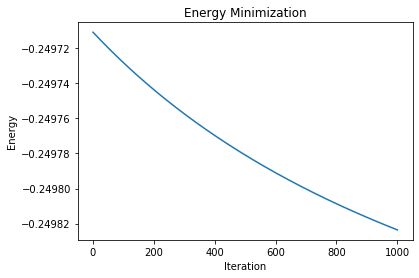

In [539]:
plt.title("Energy Minimization")
plt.plot(iteration,E)
plt.ylabel('Energy')
plt.xlabel('Iteration')
plt.show()

In [540]:
#Ground State
final=RBM_ansatz(par, Sbasis, N, M,sz)
final.unit()

[[ 2.67709131e+00+0.00000000e+00j -3.68572117e-16-1.60292704e-01j
   1.01539232e-15-1.64615649e+01j -8.15710321e+00+9.68465158e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.75068938e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.14945378e-07j]]


Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 1.87771843e-02+0.00000000e+00j]
 [-3.79488979e-08+0.00000000e+00j]
 [ 0.00000000e+00-9.99823693e-01j]
 [ 0.00000000e+00+1.27561445e-07j]]

In [541]:
min2 = scipy.optimize.minimize(varEnergy,par,args=(Sbasis, N, M,sz, H), method='Nelder-Mead')

[[ 2.67709131e+00+0.00000000e+00j -3.68572117e-16-1.60292704e-01j
   1.01539232e-15-1.64615649e+01j -8.15710321e+00+9.68465158e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.75068938e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.14945378e-07j]]
[[ 2.67709131e+00+0.00000000e+00j -3.68572117e-16-1.60292704e-01j
   1.01539232e-15-1.64615649e+01j -8.15710321e+00+9.68465158e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.75068938e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.14945378e-07j]]
[[ 2.67709131e+00+0.00000000e+00j -3.68572117e-16-1.60292704e-01j
   1.01539232e-15-1.64615649e+01j -8.15710321e+00+9.68465158e-16j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.75068938e-05j
   2.00000000e+00+0.00000000e+00j  1.22464680e-16-5.14945378e-07j]]
[[ 2.81250731e+00+0.00000000e+00j -3.71656437e-16-3.05535668e-01j
   1.09079159e-15-1.77013511e+01j -8.74914546e+00+1.04309104e-15j]
 [ 2.00000001e+00+0.00000000e+00j  1.22464680e-16-6.75068938e-05j


   1.99999357+2.67464527e-07j  0.03342793+8.28853648e-06j]]
[[ 1.48518168+9.71643730e-01j -1.67476256+3.15437149e-01j
  18.68532037-2.37713506e+01j -5.08500405+1.17489720e+01j]
 [ 1.99976079+2.52685046e-06j  0.03918927-4.95177237e-05j
   1.9997809 +1.58336629e-06j  0.03786064+6.87998494e-06j]]
[[ 1.40758942e+00+1.19513620e+00j -1.66385495e+00+2.19810818e-01j
   1.92021865e+01-2.06122701e+01j -4.63282040e+00+1.08683159e+01j]
 [ 1.99982151e+00+2.17882923e-06j  1.18482313e-02-5.26217435e-05j
   1.99983462e+00+1.32618329e-06j  1.08478223e-02+7.33768592e-06j]]
[[ 1.285991  +1.09230476e+00j -1.76905861+2.65660925e-01j
  20.6184039 -2.20876025e+01j -3.67467224+1.21160169e+01j]
 [ 1.99981908+2.18912215e-06j  0.04290106-5.63874589e-05j
   1.99983492+1.29051017e-06j  0.04169637+5.90744960e-06j]]
[[ 1.23548833+1.17445150e+00j -1.73881871+2.60103220e-01j
  22.00982651-2.21244776e+01j -3.98720517+1.22599642e+01j]
 [ 1.99980528+2.29979857e-06j  0.04155183-5.24254145e-05j
   1.99982957+1.35640372e-06

   1.99903812+2.43867866e-06j  0.13526398-2.85819463e-05j]]
[[ 1.44195137-9.25061905e-02j -1.33396607+2.92773676e+00j
   6.90983229-2.81434027e+00j -2.73013876-6.75416670e-02j]
 [ 1.9992868 +4.73561817e-06j  0.13853556-1.30093551e-04j
   1.99924922+2.01796454e-06j  0.13992129-2.66549138e-05j]]
[[ 1.15272781-1.75435164e-01j -2.6283185 +2.89706862e+00j
   8.22394646-1.65699192e+00j -2.65771472+5.02314565e-01j]
 [ 1.99892595+6.07811834e-06j  0.14291957-1.27204374e-04j
   1.9989112 +2.70238403e-06j  0.14336676-2.38910338e-05j]]
[[ 0.56550754-2.68076031e-01j -3.95133902+2.07571903e+00j
   9.00648343+9.73989663e-02j -2.03740867+1.30979045e+00j]
 [ 1.99847288+7.13303276e-06j  0.15860219-1.36195178e-04j
   1.99846185+2.87674231e-06j  0.15888305-2.73371732e-05j]]
[[ 0.95121312-2.59852558e-01j -3.17550324+2.67913451e+00j
   8.75877556-1.24102113e+00j -2.55052232+9.16381661e-01j]
 [ 1.99903946+5.65813333e-06j  0.16914078-1.29604230e-04j
   1.99901698+2.39828978e-06j  0.16985931-2.39003327e-05j]]


    1.99370728+1.25929670e-06j   0.42035504-5.89278401e-05j]]
[[ -2.6592941 -2.28359399e+00j -20.79603413-1.19777694e+01j
    2.83228454+1.55960666e+00j   1.73131868-1.33735317e+00j]
 [  1.99299717+1.61774120e-05j   0.43705514-2.38782692e-04j
    1.99315216+1.03053184e-06j   0.43523585-6.21474957e-05j]]
[[ -4.72076651-1.08844669e+00j -16.95843841-3.32996928e+01j
    2.17666287+1.91834778e+00j   3.11504591+3.00854408e-02j]
 [  1.99006637+1.91272660e-05j   0.50366818-2.55985236e-04j
    1.99037187-6.89253185e-08j   0.50067428-6.93761013e-05j]]
[[ -4.85064953-6.75373188e-01j -15.48213163-3.53311792e+01j
    1.94110741+1.95314295e+00j   3.24261693+2.40419642e-01j]
 [  1.99061501+1.88163157e-05j   0.51317212-2.60362571e-04j
    1.9909332 -2.92911665e-07j   0.5099657 -6.94679727e-05j]]
[[ -2.56721275-2.43628274e+00j -21.57806694-1.14559784e+01j
    2.70890251+1.53606597e+00j   1.55249431-1.53092109e+00j]
 [  1.99279838+1.64232897e-05j   0.43353582-2.40587861e-04j
    1.9929381 +1.07558572e-0

   1.97292174-7.43095134e-06j  0.59153207-9.96138255e-06j]]
[[ 8.25538735-1.51369977e+00j -1.09681755+1.79214716e+02j
   0.72464256-5.90230783e+00j -3.81559986-2.50564564e-01j]
 [ 1.96893491+3.63840755e-05j  0.60795175-2.48625406e-04j
   1.96979644-8.89389972e-06j  0.60324235-2.25728209e-06j]]
[[   4.47412609-8.61082727e+00j -211.30868785+1.65371498e+02j
     6.53351278-3.23772125e+00j   -2.49500132-2.80558121e+00j]
 [   1.96256929+4.06733833e-05j    0.63410072-2.49714423e-04j
     1.96361574-1.23537417e-05j    0.62890811+1.23261006e-05j]]
[[ 7.51099885+2.70481817e+00j 63.29585113+1.37788615e+02j
  -2.79632777-4.51689366e+00j -3.7083755 +8.50565026e-01j]
 [ 1.97119027+3.44728440e-05j  0.6087381 -2.53259783e-04j
   1.97198948-7.70581502e-06j  0.60420348-1.50958082e-05j]]
[[  8.18145393-1.50648483e+00j -23.05062243+1.80242579e+02j
    0.47907937-6.08776848e+00j  -3.70860328-7.73085920e-01j]
 [  1.96500528+3.80298061e-05j   0.62454139-2.50036692e-04j
    1.96587079-9.95232364e-06j   0.620

   1.72326082e+00-1.37356767e-04j  1.10907208e+00+1.94224220e-04j]]
[[ 6.31790140e+00+1.77523395e+02j  3.86990404e+05+1.26429154e+05j
  -1.87681640e+02-5.17782160e+01j -9.72786653e-01+1.16472792e+01j]
 [ 1.61702169e+00+1.40144552e-04j  1.23483826e+00-2.11193315e-04j
   1.62554649e+00-1.86791926e-04j  1.22335302e+00+2.29656863e-04j]]
[[ 2.22377180e+02-1.04251021e+02j -6.39289774e+05+7.01386107e+05j
   1.96978827e+02-2.09730524e+02j -1.23113365e+01-5.48793275e+00j]
 [ 1.56437439e+00+1.53583023e-04j  1.28483461e+00-2.12214119e-04j
   1.57401805e+00-2.17493121e-04j  1.27287570e+00+2.48464292e-04j]]
[[ 1.96710674e+02+5.28844008e+02j  5.51839868e+06+5.38452020e+06j
  -4.99792384e+02-5.23489655e+02j -5.96762421e+00+1.78670656e+01j]
 [ 1.40845111e+00+1.83108287e-04j  1.41826940e+00-1.98812238e-04j
   1.42123220e+00-2.98732251e-04j  1.40546146e+00+2.84954135e-04j]]
[[-5.55211781e+01+1.55603700e+02j  3.44357880e+05-2.10208897e+03j
  -1.77534889e+02+1.70315210e+01j  2.94866433e+00+1.12316536e+01j

   1.15007913e+00-4.37696617e-04j  1.59134943e+00+3.14856082e-04j]]
[[-5.92835686e+02-2.83222408e+03j -3.31078431e+08-3.50726746e+08j
   3.16204935e+03+3.45540656e+03j  6.75574015e+00-3.49126899e+01j]
 [ 1.03199125e+00+2.36946184e-04j  1.65659179e+00-1.61906666e-04j
   1.05184836e+00-4.85592412e-04j  1.64344572e+00+3.18324561e-04j]]
[[ 2.10532843e+03-9.04987527e+02j -2.15558930e+08+1.52652358e+08j
   2.92318607e+03-1.97719866e+03j -3.03049361e+01-1.22392270e+01j]
 [ 1.09624957e+00+2.29778099e-04j  1.62506005e+00-1.67791753e-04j
   1.11519210e+00-4.55467192e-04j  1.61170395e+00+3.17112981e-04j]]
[[ 6.26133991e+02-2.59554275e+03j -3.67894623e+08-1.39038419e+08j
   3.97468359e+03+1.59585104e+03j -8.75482758e+00-3.32319543e+01j]
 [ 1.05008634e+00+2.34110524e-04j  1.64705994e+00-1.63586296e-04j
   1.06957296e+00-4.76766593e-04j  1.63391657e+00+3.17720813e-04j]]
[[-1.28779590e+02-2.82344559e+03j -3.59459954e+08-2.66635876e+08j
   3.62233839e+03+2.74603807e+03j  1.22475252e+00-3.47859154e+01j

   7.78863391e-01-6.14268900e-04j  1.76555519e+00+3.11804145e-04j]]
[[ 4.01018268e+03+3.93187468e+03j  2.51555193e+08+2.53578446e+09j
  -7.34875666e+02-1.00007698e+04j -3.15051318e+01+3.24764967e+01j]
 [ 8.69332437e-01+2.58134775e-04j  1.73207493e+00-1.46533810e-04j
   8.92238286e-01-5.61862825e-04j  1.71917824e+00+3.17499244e-04j]]
[[ 6.23986758e+03-3.10511101e+03j -4.02920387e+09+1.76280312e+09j
   1.19852854e+04-4.86672567e+03j -4.42547843e+01-2.05498929e+01j]
 [ 8.13826079e-01+2.64875228e-04j  1.75510013e+00-1.41289754e-04j
   8.37745826e-01-5.87377191e-04j  1.74235642e+00+3.15277601e-04j]]
[[ 2.82465135e+03-7.45657824e+03j -5.77183237e+09-2.11665162e+09j
   1.39971451e+04+5.51347523e+03j -1.92953607e+01-4.74640538e+01j]
 [ 7.79585036e-01+2.68644138e-04j  1.76885850e+00-1.37858930e-04j
   8.04106195e-01-6.02717066e-04j  1.75623943e+00+3.13175496e-04j]]
[[ 5.68192638e+03-4.49058624e+03j -4.73899326e+09+9.50074819e+08j
   1.32750194e+04-2.32578808e+03j -3.96046232e+01-2.97347629e+01j

   7.15426899e-01-6.42897984e-04j  1.78898616e+00+3.07320536e-04j]]
[[-1.10243794e+04-3.67986386e+02j  9.26091229e+09-1.05763104e+10j
  -1.52599358e+04+1.64396931e+04j  5.67246540e+01-3.54088701e+00j]
 [ 6.93398059e-01+2.79308908e-04j  1.79973595e+00-1.30434986e-04j
   7.19440110e-01-6.41044825e-04j  1.78742086e+00+3.07663023e-04j]]
[[-1.07477997e+04+5.36837269e+03j  1.64544341e+10-5.88627198e+09j
  -2.36390704e+04+7.77664512e+03j  5.29622129e+01+2.47583168e+01j]
 [ 6.70318634e-01+2.81837194e-04j  1.80763831e+00-1.28251393e-04j
   6.96738134e-01-6.51201784e-04j  1.79543045e+00+3.05824834e-04j]]
[[-1.01971077e+04+6.84639456e+03j  1.81195033e+10-3.79194437e+09j
  -2.51558390e+04+4.60954618e+03j  4.97510656e+01+3.16051691e+01j]
 [ 6.64338162e-01+2.82591615e-04j  1.80950816e+00-1.27821249e-04j
   6.90839631e-01-6.53769419e-04j  1.79733166e+00+3.05357888e-04j]]
[[-6.28013549e+03+1.17883261e+04j  2.19395158e+10+6.46121529e+09j
  -2.69370572e+04-8.74649299e+03j  2.98948939e+01+5.25423456e+01j

   5.86597352e-01-6.99192552e-04j  1.83139098e+00+2.94781766e-04j]]
[[ 1.21545312e+04+1.13510920e+04j -1.97985004e+09+3.99244272e+10j
   2.90056954e+03-3.73598203e+04j -4.56491663e+01+4.50616702e+01j]
 [ 5.81968627e-01+2.92022709e-04j  1.83593043e+00-1.20463598e-04j
   6.09943533e-01-6.89157607e-04j  1.82410910e+00+2.97368488e-04j]]
[[ 1.54713319e+04+8.02099008e+03j -1.44988113e+10+4.26041505e+10j
   1.38194208e+04-3.72115131e+04j -5.69224971e+01+3.15165557e+01j]
 [ 5.69303464e-01+2.93372302e-04j  1.83979353e+00-1.19248993e-04j
   5.97490974e-01-6.94495435e-04j  1.82803759e+00+2.96010445e-04j]]
[[ 1.79830688e+04+3.40112334e+03j -2.97635885e+10+4.13611025e+10j
   2.56234480e+04-3.35705762e+04j -6.44229449e+01+1.40686600e+01j]
 [ 5.55873240e-01+2.94850715e-04j  1.84386902e+00-1.18026223e-04j
   5.84302351e-01-7.00141286e-04j  1.83217816e+00+2.94443857e-04j]]
[[ 1.79017138e+04+3.60623915e+03j -2.91404635e+10+4.14594972e+10j
   2.51798207e+04-3.38264153e+04j -6.41480334e+01+1.47450580e+01j

   5.10067221e-01-7.30705237e-04j  1.85375030e+00+2.85280046e-04j]]
[[-4.41237312e+03-2.48275379e+04j -6.01178156e+10-9.72640276e+10j
   3.23835214e+04+5.58165527e+04j  1.03630244e+01-6.94863894e+01j]
 [ 4.65923861e-01+3.03919914e-04j  1.86890274e+00-1.09610603e-04j
   4.95967510e-01-7.36453758e-04j  1.85765768e+00+2.83403030e-04j]]
[[ 1.02610278e+04-2.01900191e+04j -8.17038236e+10-3.07682313e+10j
   5.17803641e+04+2.12393301e+04j -3.29864289e+01-6.04564736e+01j]
 [ 4.96124730e-01+3.01020026e-04j  1.86078646e+00-1.12512852e-04j
   5.25630506e-01-7.24489240e-04j  1.84938340e+00+2.87318692e-04j]]
[[ 5.42173835e+03-2.29310492e+04j -7.93318727e+10-5.45804119e+10j
   4.77215519e+04+3.48104716e+04j -1.77738345e+01-6.68490844e+01j]
 [ 4.84944911e-01+3.01994197e-04j  1.86376658e+00-1.11383251e-04j
   5.14656118e-01-7.28789885e-04j  1.85241649e+00+2.85936014e-04j]]
[[ 5.65317254e+03-2.28379055e+04j -7.97307135e+10-5.36336808e+10j
   4.78399888e+04+3.42100865e+04j -1.86128658e+01-6.68911669e+01j

   4.47544320e-01-7.55539834e-04j  1.87041218e+00+2.76606010e-04j]]
[[-2.23569252e+04-1.74927528e+04j  2.83845844e+10-1.51169070e+11j
  -1.61928079e+04+7.43463414e+04j  5.48049804e+01-4.54716119e+01j]
 [ 4.31840134e-01+3.07087549e-04j  1.87762551e+00-1.06398938e-04j
   4.62525836e-01-7.49652150e-04j  1.86654978e+00+2.78757959e-04j]]
[[-2.65173651e+04-1.27039924e+04j  6.61866151e+10-1.54381628e+11j
  -3.36304014e+04+7.24640125e+04j  6.35627342e+01-3.27779723e+01j]
 [ 4.21786978e-01+3.08025101e-04j  1.88015883e+00-1.05447497e-04j
   4.52663121e-01-7.53536131e-04j  1.86913564e+00+2.77317817e-04j]]
[[-2.81143397e+04-1.01444850e+04j  8.49636988e+10-1.53119604e+11j
  -4.17501676e+04+7.01466270e+04j  6.67561727e+01-2.63882768e+01j]
 [ 4.17156232e-01+3.08498530e-04j  1.88135268e+00-1.05027449e-04j
   4.48114662e-01-7.55388338e-04j  1.87035758e+00+2.76609439e-04j]]
[[-2.80531952e+04-1.02382490e+04j  8.42141856e+10-1.53069622e+11j
  -4.14727173e+04+7.03044179e+04j  6.65741243e+01-2.65745285e+01j

   3.96587261e-01-7.74735903e-04j  1.88323353e+00+2.68722578e-04j]]
[[-2.46241884e+04+2.64123282e+04j  2.77256781e+11+3.07329900e+10j
  -1.05793512e+05-1.48971019e+04j  5.08550784e+01+5.14004805e+01j]
 [ 3.62495605e-01+3.12937310e-04j  1.89440711e+00-9.95289637e-05j
   3.94536076e-01-7.75480338e-04j  1.88369314e+00+2.68437474e-04j]]
[[-2.91437705e+04+1.88535477e+04j  2.50416186e+11-3.47688922e+10j
  -1.00355234e+05+1.09233583e+04j  6.17240079e+01+3.73770267e+01j]
 [ 3.74098948e-01+3.11973656e-04j  1.89174671e+00-1.00653501e-04j
   4.05920025e-01-7.71216009e-04j  1.88096905e+00+2.70184256e-04j]]
[[-2.95388582e+04+1.78915100e+04j  2.46298112e+11-4.17006818e+10j
  -9.93106548e+04+1.37891683e+04j  6.28038988e+01+3.55166905e+01j]
 [ 3.75490812e-01+3.11887748e-04j  1.89139833e+00-1.00820902e-04j
   4.07282071e-01-7.70732987e-04j  1.88061306e+00+2.70420660e-04j]]
[[-2.83096034e+04+2.05953191e+04j  2.57392136e+11-2.13982870e+10j
  -1.02101742e+05+5.43436107e+03j  5.95973768e+01+4.06851955e+01j

   3.56548823e-01-7.89271115e-04j  1.89267389e+00+2.62197737e-04j]]
[[ 5.87422142e+03+4.12413126e+04j  2.12682834e+11+3.32784596e+11j
  -6.75104810e+04-1.13151319e+05j -7.95437906e+00+7.14991939e+01j]
 [ 3.21173871e-01+3.16090873e-04j  1.90376143e+00-9.52983861e-05j
   3.54098565e-01-7.90151831e-04j  1.89325905e+00+2.61767586e-04j]]
[[ 5.86023823e+03+4.12443510e+04j  2.12671062e+11+3.32683321e+11j
  -6.75758607e+04-1.13137675e+05j -7.95270077e+00+7.14687940e+01j]
 [ 3.21122214e-01+3.16058669e-04j  1.90376312e+00-9.52788859e-05j
   3.54046533e-01-7.90130586e-04j  1.89326101e+00+2.61765760e-04j]]
[[-3.65475291e+03+3.99669684e+04j  2.59136353e+11+2.50940146e+11j
  -8.69032579e+04-8.94662065e+04j  8.75646441e+00+7.15155053e+01j]
 [ 3.31993019e-01+3.15288924e-04j  1.90136881e+00-9.64095257e-05j
   3.64688462e-01-7.86351937e-04j  1.89080906e+00+2.63537474e-04j]]
[[-4.23957576e+03+3.98093612e+04j  2.61253344e+11+2.45517775e+11j
  -8.79461954e+04-8.78617577e+04j  9.81550792e+00+7.13504533e+01j

   3.32268084e-01-7.97743960e-04j  1.89820079e+00+2.58039941e-04j]]
[[ 2.94095049e+04+3.47866260e+04j  5.24579573e+09+4.89116601e+11j
   3.00300422e+03-1.50787179e+05j -4.42890645e+01+5.57435716e+01j]
 [ 2.95274366e-01+3.17843015e-04j  1.90935557e+00-9.25531674e-05j
   3.28787262e-01-7.98950773e-04j  1.89898284e+00+2.57429646e-04j]]
[[ 2.83688222e+04+3.53920665e+04j  1.76838267e+10+4.84013089e+11j
  -8.83718798e+02-1.49853960e+05j -4.28504722e+01+5.69253898e+01j]
 [ 2.96424187e-01+3.17763586e-04j  1.90909766e+00-9.26846221e-05j
   3.29905593e-01-7.98570125e-04j  1.89872000e+00+2.57638923e-04j]]
[[ 2.63165001e+04+3.64828200e+04j  4.11925753e+10+4.73391496e+11j
  -8.25130538e+03-1.47755018e+05j -3.99521102e+01+5.91466720e+01j]
 [ 2.98808010e-01+3.17659379e-04j  1.90858029e+00-9.29727474e-05j
   3.32231734e-01-7.97814821e-04j  1.89819103e+00+2.58055157e-04j]]
[[ 2.52446580e+04+3.70108400e+04j  5.31200658e+10+4.67328987e+11j
  -1.21015703e+04-1.46581390e+05j -3.83934198e+01+6.01673665e+01j

   2.99003997e-01-8.09109022e-04j  1.90535894e+00+2.52292347e-04j]]
[[ 4.89924453e+04+1.15243091e+04j -3.62447065e+11+5.04257450e+11j
   1.07361444e+05-1.39921720e+05j -6.75822485e+01+1.81367801e+01j]
 [ 2.65821165e-01+3.19780950e-04j  1.91536872e+00-8.95113346e-05j
   3.00013006e-01-8.08743702e-04j  1.90514254e+00+2.52474365e-04j]]
[[ 5.04158059e+04+7.56067033e+03j -4.14723602e+11+4.87682548e+11j
   1.20830944e+05-1.33422068e+05j -6.86489756e+01+1.24903794e+01j]
 [ 2.62012514e-01+3.20005680e-04j  1.91612596e+00-8.91083304e-05j
   2.96293673e-01-8.09974426e-04j  1.90591876e+00+2.51825699e-04j]]
[[ 4.70269136e+04+1.57815671e+04j -3.03854366e+11+5.17284175e+11j
   9.19214413e+04-1.45812980e+05j -6.57995116e+01+2.43934169e+01j]
 [ 2.70144772e-01+3.19526478e-04j  1.91450396e+00-8.99687530e-05j
   3.04237715e-01-8.07337428e-04j  1.90425561e+00+2.53208591e-04j]]
[[ 4.87560342e+04+1.20717459e+04j -3.54964204e+11+5.06083877e+11j
   1.05460462e+05-1.40744695e+05j -6.73782930e+01+1.89380785e+01j

[[ 5.27303140e+04-6.41480132e+03j -5.83279027e+11+3.97453519e+11j
   1.62616881e+05-1.03516216e+05j -6.86666194e+01-6.17952069e+00j]
 [ 2.49514543e-01+3.20751263e-04j  1.91851035e+00-8.78426645e-05j
   2.84093859e-01-8.13941753e-04j  1.90836073e+00+2.49755621e-04j]]
[[ 5.27001497e+04-1.04909790e+04j -6.28705501e+11+3.62608271e+11j
   1.73136276e+05-9.27011697e+04j -6.78560218e+01-1.12894576e+01j]
 [ 2.46033793e-01+3.20990782e-04j  1.91917649e+00-8.75042631e-05j
   2.80691791e-01-8.15091680e-04j  1.90904506e+00+2.49165401e-04j]]
[[ 5.26478109e+04-1.15397535e+04j -6.39885808e+11+3.52996955e+11j
   1.75736486e+05-8.98651866e+04j -6.75445880e+01-1.25900967e+01j]
 [ 2.45141416e-01+3.21026441e-04j  1.91934956e+00-8.74008455e-05j
   2.79822912e-01-8.15353016e-04j  1.90922197e+00+2.49009622e-04j]]
[[ 5.27518256e+04-7.67287130e+03j -5.97441998e+11+3.87102682e+11j
   1.65952647e+05-1.00270490e+05j -6.84507194e+01-7.76673096e+00j]
 [ 2.48449585e-01+3.20830389e-04j  1.91871272e+00-8.77425913e-05j


   2.58952251e-01-8.21936411e-04j  1.91318916e+00+2.45500827e-04j]]
[[ 4.40550599e+04-3.77384100e+04j -8.69440834e+11+1.40015706e+10j
   2.24229728e+05+3.48293224e+03j -5.21257917e+01-4.18487725e+01j]
 [ 2.22291791e-01+3.22297313e-04j  1.92348298e+00-8.51288831e-05j
   2.57528271e-01-8.22387279e-04j  1.91345708e+00+2.45257672e-04j]]
[[ 4.15081561e+04-4.14595183e+04j -8.91397273e+11-5.31276975e+10j
   2.27850802e+05+2.08413163e+04j -4.85448418e+01-4.54879834e+01j]
 [ 2.18743531e-01+3.22485200e-04j  1.92410595e+00-8.47786863e-05j
   2.54067526e-01-8.23459799e-04j  1.91409547e+00+2.44677235e-04j]]
[[ 4.41811151e+04-3.75560016e+04j -8.68725977e+11+1.71312521e+10j
   2.23937500e+05+2.67568662e+03j -5.23373735e+01-4.16897086e+01j]
 [ 2.22476547e-01+3.22300403e-04j  1.92346355e+00-8.51452716e-05j
   2.57706654e-01-8.22352095e-04j  1.91343820e+00+2.45272071e-04j]]
[[ 4.42109657e+04-3.75044633e+04j -8.68357737e+11+1.79697123e+10j
   2.23887950e+05+2.44892812e+03j -5.23785849e+01-4.16391982e+01j

   2.33743427e-01-8.29663003e-04j  1.91770389e+00+2.41326255e-04j]]
[[ 2.82756358e+04-5.44325840e+04j -9.27475025e+11-3.52050919e+11j
   2.29063271e+05+9.54910538e+04j -3.18950530e+01-5.68223727e+01j]
 [ 2.04502954e-01+3.23241253e-04j  1.92653292e+00-8.34111023e-05j
   2.40178979e-01-8.27728170e-04j  1.91658265e+00+2.42383011e-04j]]
[[ 2.66444532e+04-5.55691496e+04j -9.25911491e+11-3.85312034e+11j
   2.27885096e+05+1.03550816e+05j -2.99864891e+01-5.76754873e+01j]
 [ 2.03021675e-01+3.23309267e-04j  1.92678537e+00-8.32620336e-05j
   2.38736029e-01-8.28156090e-04j  1.91684116e+00+2.42138556e-04j]]
[[ 2.51264374e+04-5.65552817e+04j -9.23474814e+11-4.15639227e+11j
   2.26603079e+05+1.10881429e+05j -2.82345400e+01-5.83874145e+01j]
 [ 2.01671249e-01+3.23369209e-04j  1.92701107e+00-8.31281211e-05j
   2.37420226e-01-8.28544948e-04j  1.91707224e+00+2.41920905e-04j]]
[[ 2.36262358e+04-5.74658239e+04j -9.20225649e+11-4.45227266e+11j
   2.25134383e+05+1.18012114e+05j -2.65326204e+01-5.90278996e+01j

   2.17191996e-01-8.34412603e-04j  1.92048824e+00+2.38638132e-04j]]
[[-2.85708485e+03-6.59994830e+04j -7.53152012e+11-9.06296951e+11j
   1.75799889e+05+2.25999758e+05j  6.85142845e-01-6.22798164e+01j]
 [ 1.80211406e-01+3.24302332e-04j  1.93046056e+00-8.10660146e-05j
   2.16519159e-01-8.34588750e-04j  1.92060193e+00+2.38524222e-04j]]
[[-2.90822982e+03-6.59835295e+04j -7.52384963e+11-9.06618076e+11j
   1.75658143e+05+2.26244593e+05j  7.18748875e-01-6.22563797e+01j]
 [ 1.80184874e-01+3.24320627e-04j  1.93044767e+00-8.10840417e-05j
   2.16493062e-01-8.34607613e-04j  1.92058807e+00+2.38543232e-04j]]
[[-6.92318081e+03-6.62369722e+04j -7.11075307e+11-9.67918988e+11j
   1.64703983e+05+2.40230911e+05j  4.42706464e+00-6.17412808e+01j]
 [ 1.77391180e-01+3.24438866e-04j  1.93087815e+00-8.08243756e-05j
   2.13773216e-01-8.35379073e-04j  1.92102826e+00+2.38111102e-04j]]
[[ 4.40142814e+03-6.48638261e+04j -8.17187104e+11-7.89316683e+11j
   1.93335639e+05+1.99328333e+05j -6.30689204e+00-6.26000778e+01j

   2.06177346e-01-8.37485577e-04j  1.92222842e+00+2.36921503e-04j]]
[[-2.05063659e+04-6.52870700e+04j -5.41221115e+11-1.15874756e+12j
   1.21147757e+05+2.83409458e+05j  1.62556630e+01-5.84011200e+01j]
 [ 1.68087441e-01+3.24818098e-04j  1.93227330e+00-7.99757915e-05j
   2.04719358e-01-8.37902221e-04j  1.92245340e+00+2.36698730e-04j]]
[[-1.64634839e+04-6.58595136e+04j -5.96594333e+11-1.10435248e+12j
   1.35256187e+05+2.71273351e+05j  1.28489769e+01-5.96136027e+01j]
 [ 1.70842982e-01+3.24694070e-04j  1.93186342e+00-8.02197103e-05j
   2.07402251e-01-8.37141219e-04j  1.92203428e+00+2.37115109e-04j]]
[[-1.87172814e+04-6.55737745e+04j -5.66221277e+11-1.13488209e+12j
   1.27545527e+05+2.78124965e+05j  1.47613671e+01-5.89499793e+01j]
 [ 1.69302213e-01+3.24753243e-04j  1.93209427e+00-8.00773367e-05j
   2.05902986e-01-8.37554185e-04j  1.92227015e+00+2.36879471e-04j]]
[[-1.57215136e+04-6.59321009e+04j -6.06204233e+11-1.09401451e+12j
   1.37729553e+05+2.69005155e+05j  1.22105960e+01-5.98099077e+01j

   1.91905414e-01-8.41258324e-04j  1.92441038e+00+2.34706932e-04j]]
[[-4.06334478e+04-5.85516280e+04j -1.96329499e+11-1.38808521e+12j
   3.61723132e+04+3.34527471e+05j  3.17465215e+01-4.90802530e+01j]
 [ 1.53984758e-01+3.25245110e-04j  1.93432388e+00-7.86537495e-05j
   1.91012744e-01-8.41489904e-04j  1.92454418e+00+2.34569096e-04j]]
[[-4.26860529e+04-5.74612822e+04j -1.53817099e+11-1.40751398e+12j
   2.58064793e+04+3.38627383e+05j  3.31908996e+01-4.78541651e+01j]
 [ 1.52479622e-01+3.25293511e-04j  1.93454285e+00-7.85132379e-05j
   1.89549002e-01-8.41877356e-04j  1.92476796e+00+2.34337614e-04j]]
[[-4.32849692e+04-5.71276212e+04j -1.41116871e+11-1.41299701e+12j
   2.27213894e+04+3.39781503e+05j  3.36069630e+01-4.74837481e+01j]
 [ 1.52035208e-01+3.25305757e-04j  1.93460764e+00-7.84706570e-05j
   1.89116892e-01-8.41989636e-04j  1.92483418e+00+2.34268824e-04j]]
[[-3.68974336e+04-6.03363884e+04j -2.69895743e+11-1.35120531e+12j
   5.41112267e+04+3.26363784e+05j  2.90665957e+01-5.12094631e+01j

   1.83295844e-01-8.43460140e-04j  1.92566244e+00+2.33412942e-04j]]
[[-5.12077638e+04-5.18638320e+04j  4.15159770e+10-1.47397671e+12j
  -2.16248647e+04+3.53416223e+05j  3.87957864e+01-4.19474296e+01j]
 [ 1.45954381e-01+3.25480413e-04j  1.93543337e+00-7.79342793e-05j
   1.83212266e-01-8.43481501e-04j  1.92567336e+00+2.33401838e-04j]]
[[-4.78414744e+04-5.42760184e+04j -3.94282530e+10-1.44978938e+12j
  -1.98518406e+03+3.48196777e+05j  3.66371454e+01-4.44017913e+01j]
 [ 1.48589586e-01+3.25402753e-04j  1.93507094e+00-7.81693615e-05j
   1.85772160e-01-8.42828294e-04j  1.92530438e+00+2.33784981e-04j]]
[[-4.93687585e+04-5.32172917e+04j -3.39662213e+09-1.46098769e+12j
  -1.07133043e+04+3.50705063e+05j  3.76205854e+01-4.32991087e+01j]
 [ 1.47402133e-01+3.25430116e-04j  1.93523366e+00-7.80603310e-05j
   1.84619599e-01-8.43111882e-04j  1.92546973e+00+2.33612760e-04j]]
[[-4.94457208e+04-5.31605105e+04j -1.53635251e+09-1.46147240e+12j
  -1.11666484e+04+3.50837738e+05j  3.76680966e+01-4.32398134e+01j

   1.73923632e-01-8.45802925e-04j  1.92695207e+00+2.32067978e-04j]]
[[-6.42468783e+04-3.90217429e+04j  4.19014273e+11-1.52410342e+12j
  -1.13372987e+05+3.64087679e+05j  4.61590637e+01-3.01824289e+01j]
 [ 1.34515190e-01+3.25805394e-04j  1.93693558e+00-7.69559213e-05j
   1.72107493e-01-8.46246561e-04j  1.92719864e+00+2.31807847e-04j]]
[[-6.58394407e+04-3.69342259e+04j  4.74717526e+11-1.52363173e+12j
  -1.26954188e+05+3.63862539e+05j  4.69267674e+01-2.84234496e+01j]
 [ 1.32906321e-01+3.25847212e-04j  1.93714184e+00-7.68196735e-05j
   1.70546390e-01-8.46626395e-04j  1.92740781e+00+2.31586961e-04j]]
[[-6.50873705e+04-3.79429007e+04j  4.48093011e+11-1.52429068e+12j
  -1.20439724e+05+3.63989367e+05j  4.65760967e+01-2.92740557e+01j]
 [ 1.33676918e-01+3.25830779e-04j  1.93704532e+00-7.68849636e-05j
   1.71293422e-01-8.46450972e-04j  1.92731024e+00+2.31689951e-04j]]
[[-6.53476194e+04-3.75933781e+04j  4.57276896e+11-1.52406290e+12j
  -1.22702997e+05+3.63955775e+05j  4.66983081e+01-2.89809371e+01j

   1.61681396e-01-8.48649132e-04j  1.92857013e+00+2.30341336e-04j]]
[[-7.16491356e+04-2.77295752e+04j  7.06565010e+11-1.49958046e+12j
  -1.83811311e+05+3.58492203e+05j  4.92902562e+01-2.09835317e+01j]
 [ 1.26268998e-01+3.25938034e-04j  1.93797985e+00-7.62286213e-05j
   1.64115177e-01-8.48076164e-04j  1.92825507e+00+2.30678530e-04j]]
[[-7.24804879e+04-2.61279802e+04j  7.45027887e+11-1.49247034e+12j
  -1.93299038e+05+3.56797562e+05j  4.95753529e+01-1.97571716e+01j]
 [ 1.25184091e-01+3.25959827e-04j  1.93811458e+00-7.61367164e-05j
   1.63063362e-01-8.48320598e-04j  1.92839140e+00+2.30532490e-04j]]
[[-7.31564713e+04-2.47551028e+04j  7.77484292e+11-1.48555928e+12j
  -2.01338811e+05+3.55243674e+05j  4.97821376e+01-1.87107343e+01j]
 [ 1.24263084e-01+3.25969442e-04j  1.93822827e+00-7.60551014e-05j
   1.62171473e-01-8.48515692e-04j  1.92850614e+00+2.30408465e-04j]]
[[-7.25268741e+04-2.60420298e+04j  7.47051527e+11-1.49196935e+12j
  -1.93796925e+05+3.56745687e+05j  4.95824646e+01-1.96834569e+01j

   1.53612441e-01-8.50437871e-04j  1.92955758e+00+2.29278960e-04j]]
[[-7.86879292e+04-8.94487591e+03j  1.12631538e+12-1.36690770e+12j
  -2.89113626e+05+3.27549826e+05j  5.06564572e+01-7.50219190e+00j]
 [ 1.14348675e-01+3.26141948e-04j  1.93940303e+00-7.52424549e-05j
   1.52568231e-01-8.50668122e-04j  1.92969030e+00+2.29133642e-04j]]
[[-7.88061947e+04-8.44872217e+03j  1.13659057e+12-1.36204941e+12j
  -2.91732957e+05+3.26455997e+05j  5.06374330e+01-7.16554944e+00j]
 [ 1.14046540e-01+3.26137309e-04j  1.93944016e+00-7.52122058e-05j
   1.52276420e-01-8.50721393e-04j  1.92972763e+00+2.29091578e-04j]]
[[-7.81133360e+04-1.12196779e+04j  1.07838392e+12-1.38792713e+12j
  -2.77011539e+05+3.32588188e+05j  5.06753396e+01-9.03641772e+00j]
 [ 1.15722709e-01+3.26122504e-04j  1.93923760e+00-7.53592661e-05j
   1.53899169e-01-8.50373707e-04j  1.92952324e+00+2.29315961e-04j]]
[[-7.87947703e+04-8.48156786e+03j  1.13567255e+12-1.36219469e+12j
  -2.91574298e+05+3.26575274e+05j  5.06277320e+01-7.18613971e+00j

In [583]:
print(min2.message)
RBM_ansatz(min2.x, Sbasis, N, M,sz)

Maximum number of function evaluations has been exceeded.
[[-8.06635115e+04+5.85610404e+03j  1.41457372e+12-1.19583155e+12j
  -3.64621489e+05+2.87380502e+05j  4.93168887e+01+1.88106023e+00j]
 [ 1.05710546e-01+3.26231334e-04j  1.94036509e+00-7.45505522e-05j
   1.44213620e-01-8.52411565e-04j  1.93065424e+00+2.28084525e-04j]]


Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[-1.67843555e-09+1.11844506e-10j]
 [ 5.46450901e-01-4.48865497e-01j]
 [-5.46400474e-01+4.48727855e-01j]
 [ 1.00557762e-03+3.56060968e-05j]]

In [544]:
varEnergy(min2.x, Sbasis, N, M,sz, H)

[[-8.06635115e+04+5.85610404e+03j  1.41457372e+12-1.19583155e+12j
  -3.64621489e+05+2.87380502e+05j  4.93168887e+01+1.88106023e+00j]
 [ 1.05710546e-01+3.26231334e-04j  1.94036509e+00-7.45505522e-05j
   1.44213620e-01-8.52411565e-04j  1.93065424e+00+2.28084525e-04j]]


-0.7499989768016958

In [584]:
print(min2.fun)

-0.7499989768016958


In [580]:
a[0]

TypeError: 'dict_values' object is not subscriptable